<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [1]:
import os
import sys
import json

import statistics
import collections
import operator
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from matplotlib import colors
import matplotlib.patches as mpatches

from collections import Counter
from collections import OrderedDict

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from  matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

from numpy import std
from numpy import mean
from numpy import percentile

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

In [2]:
tracks = pd.read_csv('../../data/fma_metadata/tracks.csv', index_col=0, header=[0, 1])
tracks.shape

(106574, 52)

In [3]:
tracks.head(3).T

track_id                                                                  2  \
album  comments                                                           0   
       date_created                                     2008-11-26 01:44:45   
       date_released                                    2009-01-05 00:00:00   
       engineer                                                         NaN   
       favorites                                                          4   
       id                                                                 1   
       information                                                  <p></p>   
       listens                                                         6073   
       producer                                                         NaN   
       tags                                                              []   
       title                                           AWOL - A Way Of Life   
       tracks                                                             7   
       type                                                           Album   
artist active_year_begin                                2006-01-01 00:00:00   
       active_year_end                                                  NaN   
       associated_labels                                                NaN   
       bio                <p>A Way Of Life, A Collective of Hip-Hop from...   
       comments                                                           0   
       date_created                                     2008-11-26 01:42:32   
       favorites                                                          9   
       id                                                                 1   
       latitude                                                     40.0583   
       location                                                  New Jersey   
       longitude                                                   -74.4057   
       members            Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...   
       name                                                            AWOL   
       related_projects   The list of past projects is 2 long but every1...   
       tags                                                        ['awol']   
       website                      http://www.AzillionRecords.blogspot.com   
       wikipedia_page                                                   NaN   
set    split                                                       training   
       subset                                                         small   
track  bit_rate                                                      256000   
       comments                                                           0   
       composer                                                         NaN   
       date_created                                     2008-11-26 01:48:12   
       date_recorded                                    2008-11-26 00:00:00   
       duration                                                         168   
       favorites                                                          2   
       genre_top                                                    Hip-Hop   
       genres                                                          [21]   
       genres_all                                                      [21]   
       information                                                      NaN   
       interest                                                        4656   
       language_code                                                     en   
       license            Attribution-NonCommercial-ShareAlike 3.0 Inter...   
       listens                                                         1293   
       lyricist                                                         NaN   
       number                                                             3   
       publisher                                  

<h1>DataFrame's headers </h1>

In [4]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 52 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   (album, comments)            106574 non-null  int64  
 1   (album, date_created)        103045 non-null  object 
 2   (album, date_released)       70294 non-null   object 
 3   (album, engineer)            15295 non-null   object 
 4   (album, favorites)           106574 non-null  int64  
 5   (album, id)                  106574 non-null  int64  
 6   (album, information)         83149 non-null   object 
 7   (album, listens)             106574 non-null  int64  
 8   (album, producer)            18060 non-null   object 
 9   (album, tags)                106574 non-null  object 
 10  (album, title)               105549 non-null  object 
 11  (album, tracks)              106574 non-null  int64  
 12  (album, type)                100066 non-null  object 
 13 

In [5]:
def sns_barplot_x_and_y(param_dict, x_label, title, log_flag, rotation_flag):
    sns.barplot(x=list(param_dict.keys()), y=list(param_dict.values()), color="#4C72B0")
    if log_flag:
        plt.yscale('log')
    if rotation_flag:
        plt.xticks(rotation=90)
    plt.xlabel(x_label)
    plt.ylabel("count")
    plt.title(title)
    plt.show()

<h1> DataFrame's numerical statistics</h1>

In [6]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_tracks = tracks.select_dtypes(include=numerics)
numeric_tracks.shape

(106574, 17)

<h3>Numerical features -1 insight (among which many album features) </h3>

In [7]:
minus_ones_columns = [('album', 'comments'), ('album', 'favorites'), ('album', 'id'), ('album', 'listens'),
                      ('album', 'tracks'), ('artist', 'comments'), ('artist', 'favorites'), 
                      ('track', 'bit_rate')]

In [8]:
unknown_album_idx = tracks[(tracks[('album', 'comments')] == -1) &
       (tracks[('album', 'favorites')] == -1) &
       (tracks[('album', 'id')] == -1) &
       (tracks[('album', 'listens')] == -1) &
       (tracks[('album', 'tracks')] == -1)].index
if len(unknown_album_idx) != tracks[tracks[('album', 'id')] == -1].shape[0]:
    print("-1 mismatch among albums' ID, comments, favorites, listens and tracks")
else:
    print("-1 MATCH among albums' ID, comments, favorites, listens and tracks")
    print("unknown_album_idx", len(unknown_album_idx))

-1 MATCH among albums' ID, comments, favorites, listens and tracks
unknown_album_idx 1025


In [9]:
def get_year_month_day(datetime_str):
    tmp_list = datetime_str.split("-")
    year = tmp_list[0]
    month = tmp_list[1]
    day = tmp_list[2].split(" ")[0]
    return int(year), int(month), int(day)

In [10]:
# check if among missing album's ids, exist tracks, belonging to the same artist
# and having the same title. If exist, we can impute tracks missing album id, 
# with the matching album infos (N.B. more than one album can be matched)
album_columns = [column_name for column_name in tracks.columns if column_name[0] == 'album']

replaced_album_id_indeces = []
max_album_id = tracks[('album', 'id')].max()
print("max_album_id", max_album_id)
incr_id = max_album_id
for idx in unknown_album_idx:
    replace_flag = False
    artist = tracks.at[idx, ('artist', 'id')]
    title = tracks.at[idx, ('track', 'title')]
    tmp_df = tracks[(tracks[('artist', 'id')] == artist) & 
                    (tracks[('track', 'title')] == title) & 
                    (tracks[('album', 'id')] != -1)]
    
    shape = tmp_df.shape[0]
    if shape > 0:  # exist a duplicate track
        index = 0
        types = list(tmp_df[('album', 'type')].unique())
        t_creation = tracks.at[idx, ('track', 'date_created')]
        t_y, t_m, t_d = get_year_month_day(t_creation)
        tracks_creation = tmp_df[('track', 'date_created')].values
        aids = tmp_df[('album', 'id')].values
        
        if "Contest" in types or "Single Tracks" in types: 
            continue  # track imputed later with consisten album type 
           
        if shape == 1:
            replace_flag = True
        elif shape == 2:
            # solve tie
            y1, m1, d1 =  get_year_month_day(tracks_creation[0])
            y2, m2, d2 =   get_year_month_day(tracks_creation[1])
            if t_y == y1 and t_m == m1 and t_d == d1:
                replace_flag = True
            elif t_y == y2 and t_m == m2 and t_d == d2:
                index = 1
                replace_flag = True
            else:
                # choosing arbitrarly to assign track to first album
                # since ('track', 'date_created') is unconstrained
                replace_flag = True
        else:
            print("Not contemplated album match=%s yet" % shape)
            sys.exit(-1)
        if replace_flag:
            replaced_album_id_indeces.append(idx)
            for column_name in album_columns:
                tracks.at[idx, column_name] = tmp_df[column_name].values[index]   
    else:
        # incrementally replace missing album ID 
        incr_id += 1
        tracks.at[idx, ('album', 'id')] = incr_id

# checking
print("('album', 'id')", tracks[tracks[('album', 'id')] == -1].shape[0])
print("replaced_album_id_indeces", len(replaced_album_id_indeces))

max_album_id 22940
('album', 'id') 0
replaced_album_id_indeces 105


**10.24% missing album ids were imputed using existing album ids present in the dataset, while the remaining part was imputed sequentially incrementing greatest album ID present in the dataset.**

<h3>Checking other numerical missing values</h3>

In [11]:
def sns_barplot(df, column_name, x_label, x_ticks_rotation_flag, y_log_flag, title):
    count_dict = Counter(df[column_name].dropna())  # N.B. = removing NaN values
    count_dict = dict(sorted(count_dict.items(),key=operator.itemgetter(1),reverse=True))
    y = list(count_dict.keys())
    x = list(count_dict.values())
    sns.barplot(x=x, y=y, log=y_log_flag, color="#4C72B0")
    if x_ticks_rotation_flag:
        plt.xticks(rotation=90)
    plt.xlabel(x_label)
    plt.ylabel("count")
    plt.title(title)
    plt.show()

<h1>Categorical features insight</h1>

In [12]:
categorical_tracks = tracks.select_dtypes('object')
categorical_tracks.shape

(106574, 35)

In [13]:
# converting columns relative to dates to datetime64[ns] type
dates_columns = [('album', 'date_created'), ('album', 'date_released'), ('artist', 'active_year_begin'), 
                 ('artist', 'active_year_end'), ('artist', 'date_created'), ('track', 'date_created'),
                 ('track', 'date_recorded')]
for dcolumn in dates_columns:
    tracks[dcolumn] = pd.to_datetime(tracks[dcolumn], infer_datetime_format=True)

In [14]:
datetime_tracks = tracks.select_dtypes('datetime64')
datetime_tracks.shape

(106574, 7)

In [15]:
def support_transform_column_in_years_and_months(df, column_name):
    years_column = []
    months_colum = []
    for row in df[column_name]:
        years_column.append(row.year)
        months_colum.append(row.month)
    if len(years_column) != df.shape[0] or len(months_colum) != df.shape[0]:
        print("not matching column's length")
    return years_column, months_colum

In [16]:
# splitting datetime64[ns] into year and month
original_datetime_column = list(datetime_tracks.columns)
for column_name in original_datetime_column:
    years_column, months_column  = support_transform_column_in_years_and_months(datetime_tracks, column_name)
    column_index = datetime_tracks.columns.get_loc(column_name)
    new_years_column_name = (column_name[0], column_name[1] + "_year")
    new_months_column_name = (column_name[0], column_name[1] + "_month")
    datetime_tracks.insert(loc=column_index, column=new_years_column_name, value=years_column)
    datetime_tracks.insert(loc=column_index+1, column=new_months_column_name, value=months_column)
    
# drop old datetime64[ns] columns
for column_name in original_datetime_column:
    del datetime_tracks[column_name]
datetime_tracks.shape

(106574, 14)

<h6>Checking correlation among datetime columns</h6>

In [17]:
def normalize_df(df, scaler_flag):
    # for column_name in columns_to_normalize:
    column_names = list(df.columns)
    for column_name in column_names:
        data = df[column_name]
        scaler = None
        if scaler_flag == "min_max":
            scaler = MinMaxScaler()
        elif scaler_flag == "standard":
            scaler = StandardScaler()
        elif scaler_flag == "maxabs":
            scaler = MaxAbsScaler()
        elif scaler_flag == "robust":
            scaler = RobustScaler()
        else:
            print("scaler_flag error")
            sys.exit(-1)
        # fit the model on the feature to normale its values and transform it
        df[column_name] = scaler.fit_transform(df[column_name].values.reshape(-1,1))[:, 0]
    return df

<h6>Removing all datetime columns, a part from  ('track', 'date_created') from original DataFrame.</h6>

In [18]:
def transform_list_into_seasons(months_list):
    season_list = []
    for m in months_list:
        if m == 3 or m == 4 or m == 5:
            season_list.append("Spring")
        if m == 6 or m == 7 or m == 8:
            season_list.append("Summer")
        if m == 9 or m == 10 or m == 11:
            season_list.append("Autumn")
        if m == 12 or m == 1 or m == 2:
            season_list.append("Winter")
            
    if len(season_list) != len(months_list):
        print("Lists lenght missmatch")
        sys.exit(-1)
    return season_list

In [19]:
# removing all all datetime columns, a part from ('track', 'date_created') f
dates_columns = [('album', 'date_created'), ('album', 'date_released'), ('artist', 'active_year_begin'), 
                 ('artist', 'active_year_end'), ('artist', 'date_created'), ('track', 'date_recorded')]
for dcolumn in dates_columns:
    del tracks[dcolumn] 
    
# splitting datetime64[ns] into year and month
original_datetime_column = [('track', 'date_created')]
for column_name in original_datetime_column:
    years_column, months_column  = support_transform_column_in_years_and_months(tracks, column_name)
    season_column = transform_list_into_seasons(months_column)
    column_index = tracks.columns.get_loc(column_name)
    new_years_column_name = (column_name[0], column_name[1] + "_year")
    new_months_column_name = (column_name[0], column_name[1] + "_season")
    tracks.insert(loc=column_index, column=new_years_column_name, value=years_column)
    tracks.insert(loc=column_index+1, column=new_months_column_name, value=season_column)
    
# drop old datetime64[ns] columns
for column_name in original_datetime_column:
    del tracks[column_name]
tracks.shape

(106574, 47)

<h2>Tracks' genre_top understanding </h2>

In [20]:
def sns_barplot(df, column_name, x_label, x_ticks_rotation_flag, y_log_flag, title):
    count_dict = Counter(df[column_name].dropna())  # N.B. = removing NaN values
    count_dict = dict(sorted(count_dict.items(),key=operator.itemgetter(1),reverse=True))
    y = list(count_dict.keys())
    x = list(count_dict.values())
    sns.barplot(x=x, y=y, log=y_log_flag, color="#4C72B0")
    if x_ticks_rotation_flag:
        plt.xticks(rotation=90)
    plt.xlabel(x_label)
    plt.ylabel("count")
    plt.title(title)
    plt.show()

In [21]:
def sns_histplot(df, column_name, log_flag, horizontal_flag, title):
    if horizontal_flag:
        sns.histplot(y=column_name, data=df, color="#4C72B0")
        plt.yticks(list(df[column_name].dropna().unique()))
        if log_flag:
            plt.xscale('log')
        plt.ylabel(str(column_name))
        plt.xlabel("count")
    else:
        sns.histplot(x=column_name, data=df, color="#4C72B0")
        plt.xticks(list(df[column_name].dropna().unique()))
        if log_flag:
            plt.yscale('log')
        plt.xlabel(str(column_name))
        plt.ylabel("count")
    plt.title(title)
    plt.show()

In [22]:
def sns_countplot(df, column_name, ax, log_flag, horizontal_flag):
      
    # create a list to collect the plt.patches data
    percentages = []
    # find the values and append to list
    for value in reversed(df[column_name].value_counts().index):
        perc = df[df[column_name] == value].shape[0] / df.shape[0]*100
        percentages.append(perc)
    
    if horizontal_flag:
        if "AxesSubplot" not in str(ax):
            ax = sns.countplot(y=column_name, data=df, color="#4C72B0", order=reversed(df[column_name].value_counts().index))
        else:
            sns.countplot(y=column_name, data=df, color="#4C72B0", ax=ax, order=reversed(df[column_name].value_counts().index))
        
        if log_flag:
            plt.xscale('log')
        plt.ylabel(str(column_name))
        plt.xlabel("count")
            
        # set individual bar lables using above list
        for i, perc  in zip(ax.patches, percentages):
            # get_width pulls left or right; get_y pushes up or down
            ax.text(i.get_width()+100, i.get_y()+.18, "%.1f%%" % perc)
        # invert for largest on top 
        ax.invert_yaxis()
        
    else:
        if "AxesSubplot" not in str(ax):
            ax = sns.countplot(x=column_name, data=df, color="#4C72B0", order=reversed(df[column_name].value_counts().index))
        else:
            sns.countplot(x=column_name, data=df, color="#4C72B0", ax=ax, order=reversed(df[column_name].value_counts().index))
            
        if log_flag:
            plt.yscale('log')
        plt.xlabel(str(column_name))
        plt.ylabel("count")
        plt.xticks(sorted(list(df[column_name].dropna().unique())))
        
    plt.title("%s distribution" % str(column_name))
    if "AxesSubplot" not in str(ax):
        plt.show()

In [23]:
def sns_boxplot_ordered_by_mean(df, category_name, numerical_name, ax, horizontal_flag, showfliers):
    grouped = df.loc[:,[category_name, numerical_name]].dropna() \
    .groupby([category_name]) \
    .mean() \
    .sort_values(by=numerical_name)
    
    plt.title("%s per %s distribution" % (str(numerical_name), str(category_name)))
    if horizontal_flag:
        x = df[numerical_name]
        y = df[category_name]
    else:
        y = df[numerical_name]
        x = df[category_name]
        plt.xticks(rotation=90)
    if "AxesSubplot" not in str(ax):
        sns.boxplot(x=x, y=y, order=grouped.index, color="#4C72B0", showfliers=showfliers)
        plt.show()
    else:
        sns.boxplot(x=x, y=y, order=grouped.index, color="#4C72B0", showfliers=showfliers, ax=ax)

In [24]:
def sns_scatterplot(df, x_column_name, y_column_name, hue_column_name, x_ticks_rotation_flag, title):
    if hue_column_name == "":
        scatter = sns.scatterplot(x=x_column_name, y=y_column_name, data=df.dropna(), color="#4C72B0")
    else:
        scatter = sns.scatterplot(x=x_column_name, y=y_column_name, hue=hue_column_name, data=df.dropna(), palette="tab10", marker="o")
    # plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    if x_ticks_rotation_flag:
        plt.xticks(rotation=45)
    plt.title(title)
    if hue_column_name != "":
        plt.legend(title=str(hue_column_name), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.show()

In [25]:
def draw_stacked_bar(df, column_name1, column_name2, annotate_top_flag, annotate_top_perc_flag, 
                                                                             annotate_each_stack_perc_flag, ax):

    patch_handles = []
    curr_df = df[[column_name1, column_name2]].dropna()

    # get a frequency table of  column_name1 and column_name2
    pclass_xt = pd.crosstab(df[column_name1], df[column_name2]).dropna()
    if "AxesSubplot" not in str(ax):
        patch_handles.append(pclass_xt.plot(kind="bar", stacked=True, log=True))
    else:
        patch_handles.append(pclass_xt.plot(kind="bar", stacked=True, log=True, ax=ax))
    plt.xlabel(column_name1)
    plt.ylabel('count')
    plt.xticks(rotation=90)
    plt.legend(title=str(column_name2), bbox_to_anchor=(1.05, 1.0), loc="upper left")
    # plt.legend(title=str(column_name2), bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=2, fancybox=True, shadow=True)

    # search all of the bar segments and annotate
    unique_values = sorted(curr_df[column_name1].unique())  # alphabetical order
    tmp_xticks_tot_elements = {}
    for rec in ax.patches:
        height = rec.get_height()
        x = rec.get_x() + rec.get_width() / 2
        y = rec.get_y() + height / 2
        current_value = unique_values[int(x)]  # index with xticks unique column_name1's values
        tot_current_value = curr_df[curr_df[column_name1] == current_value][column_name1].shape[0] 
        percentage =  "{:.0f}%".format(height /tot_current_value*100)

        try:
            tmp_count = tmp_xticks_tot_elements[str(x)]
            tmp_count += height
            tmp_xticks_tot_elements[str(x)] = tmp_count
        except KeyError:
             tmp_xticks_tot_elements[str(x)] = height

        if annotate_each_stack_perc_flag:
            ax.text(x, y, percentage, ha='center', va='bottom')

    # put total number of elements on top of each bar
    if annotate_top_flag:
        for x, tot_x in tmp_xticks_tot_elements.items():
            perc = "{:.0f}%".format(int(tot_x) / curr_df.shape[0]*100)
            ax.text(float(x), tot_x, str(int(tot_x)), ha='center', va='bottom')

    if annotate_top_perc_flag:
        for x, tot_x in tmp_xticks_tot_elements.items():
            perc = "{:.0f}%".format(int(tot_x) / curr_df.shape[0]*100)
            ax.text(float(x), tot_x, perc, ha='center', va='bottom')

    plt.title("%s per %s distribution" % (str(column_name1), str(column_name2)))
    plt.show()
    return pclass_xt

In [26]:
def get_colors_list(standard_columns_order, different_columns_order):
    tmp_len = len(standard_columns_order)
    colors = list(plt.cm.tab10(np.arange(tmp_len)))
    colors = [list(elem) for elem in colors]
    colors_dict = dict(zip(standard_columns_order, colors))
    
    colors = []
    for column_name in different_columns_order:
        c = colors_dict[column_name]
        colors.append(c)
    return colors, colors_dict

In [27]:
def draw_reversed_frequency_stacked_bar(df, column_name1, column_name2, y_log_flag, x_rotate_flag,
                                                                                annotate_top_perc_flag, ax):
    alphabetical_genres = sorted(df[column_name1].dropna().unique())
    
     # get a frequency table of  column_name1 and column_name2
    pclass_xt = pd.crosstab(df[column_name1], df[column_name2]).dropna()
    
    # compute a stacked bar with decreasing frequency for each unique value in column_name1
    num_rows = len(alphabetical_genres)
    num_column = len(pclass_xt.columns)
    ordered_rows = [[]]*num_rows
    ordered_columns = [[]]*num_rows
    for i in range(0, len(alphabetical_genres)):
        g = alphabetical_genres[i]
        g_values = []
        g_first_columns = []
        for column_name in pclass_xt.columns:
            tmp_list = list(pclass_xt[column_name])
            value = tmp_list[i]
            g_values.append(value)
            g_first_columns.append(column_name)
        sorted_g_values = []
        sorted_g_first_columns = []
        for j in range(0, num_column):
            max_v = max(g_values)
            index = g_values.index(max_v)
            sorted_g_values.append(max_v)
            sorted_g_first_columns.append(g_first_columns[index])
            g_values.pop(index)
            g_first_columns.pop(index)

        ordered_rows[i] = sorted_g_values
        ordered_columns[i] = sorted_g_first_columns
    
    # draw stacked bars
    colors_dict = {}
    curr_df = df[[column_name1, column_name2]].dropna()
    for i in range(0, num_rows):
        y = ordered_rows[i]
        x = [alphabetical_genres[i]]*len(y)
        label = ordered_columns[i]
        colors, colors_dict = get_colors_list(pclass_xt.columns, label)
        bottoms = [0]  # first bar drawn at y=0
        for j in range(1, len(y)):
            j_1_elements_sum = sum(y[:j])
            bottoms.append(j_1_elements_sum)
            
        tot_elems =  sum(y)
        perc = "{:.0f}%".format(int(tot_elems) / curr_df.shape[0]*100)
        
        if "AxesSubplot" not in str(ax):
            if annotate_top_perc_flag:
                plt.text(x[0], tot_elems, perc, ha='center', va='bottom')
            plt.bar(x, y, label=label, color=colors, bottom=bottoms)
        else:
            if annotate_top_perc_flag:
                ax.text(x[0], tot_elems, perc, ha='center', va='bottom')
            plt.bar(x, y, label=label, color=colors, bottom=bottoms, ax=ax)
            
    # self-created legend
    handles = []
    for key, value in colors_dict.items():
        patch = mpatches.Patch(color=value, label=key)
        handles.append(patch)
    plt.legend(title=column_name2, handles=handles, bbox_to_anchor=(1.05, 1.0), loc="upper left")
    
    if x_rotate_flag:
        plt.xticks(rotation=90)
    if y_log_flag:
        plt.yscale("log")
    plt.xlabel(column_name1)
    plt.ylabel("count")
    plt.title("%s per %s distribution" % (str(column_name1), str(column_name2)))
    
    if "AxesSubplot" not in str(ax):
        plt.show()
    
    return pclass_xt

In [105]:
def draw_reversed_frequency_stacked_bar2(df, column_name1, column_name2, y_log_flag, x_rotate_flag,
                                                                                annotate_top_perc_flag, ax):
    alphabetical_genres = sorted(df[column_name1].dropna().unique())
    
     # get a frequency table of  column_name1 and column_name2
    pclass_xt = pd.crosstab(df[column_name1], df[column_name2]).dropna()
    
    # compute a stacked bar with decreasing frequency for each unique value in column_name1
    num_rows = len(alphabetical_genres)
    num_column = len(pclass_xt.columns)
    ordered_rows = [[]]*num_rows
    ordered_columns = [[]]*num_rows
    for i in range(0, len(alphabetical_genres)):
        g = alphabetical_genres[i]
        g_values = []
        g_first_columns = []
        for column_name in pclass_xt.columns:
            tmp_list = list(pclass_xt[column_name])
            value = tmp_list[i]
            g_values.append(value)
            g_first_columns.append(column_name)
        sorted_g_values = []
        sorted_g_first_columns = []
        for j in range(0, num_column):
            max_v = max(g_values)
            index = g_values.index(max_v)
            sorted_g_values.append(max_v)
            sorted_g_first_columns.append(g_first_columns[index])
            g_values.pop(index)
            g_first_columns.pop(index)

        ordered_rows[i] = sorted_g_values
        ordered_columns[i] = sorted_g_first_columns
    
    # draw stacked bars
    colors_dict = {}
    curr_df = df[[column_name1, column_name2]].dropna()
    for i in range(0, num_rows):
        y = ordered_rows[i]
        x = [alphabetical_genres[i]]*len(y)
        label = ordered_columns[i]
        colors, colors_dict = get_colors_list(pclass_xt.columns, label)
        bottoms = [0]  # first bar drawn at y=0
        for j in range(1, len(y)):
            j_1_elements_sum = sum(y[:j])
            bottoms.append(j_1_elements_sum)
            
        # change orange color with green and switch colors among class labels        
        # colors_dict[('', 'Studio Recording')] = colors_dict[('', 'Live Recording')]
        # tmp = colors[0] = colors_dict[('', 'Studio Recording')]
        
        colors_dict[('', 'Studio Recording')] = color="#4C72B0"
        tmp = colors[0] = color="#4C72B0"
        
        colors_dict[('', 'Live Recording')] = "mediumseagreen"
        colors[1] = "mediumseagreen"
        
        tot_elems =  sum(y)
        perc = "{:.0f}%".format(int(tot_elems) / curr_df.shape[0]*100)
        
        if "AxesSubplot" not in str(ax):
            if annotate_top_perc_flag:
                plt.text(x[0], tot_elems, perc, ha='center', va='bottom')
            plt.bar(x, y, label=label, color=colors, bottom=bottoms)
        else:
            if annotate_top_perc_flag:
                ax.text(x[0], tot_elems, perc, ha='center', va='bottom')
            plt.bar(x, y, label=label, color=colors, bottom=bottoms, ax=ax)
            
    # self-created legend
    handles = []
    for key, value in colors_dict.items():
        patch = mpatches.Patch(color=value, label=key)
        handles.append(patch)
    plt.legend(title=column_name2, handles=handles, bbox_to_anchor=(1.05, 1.0), loc="upper left")
    
    if x_rotate_flag:
        plt.xticks(rotation=90)
    if y_log_flag:
        plt.yscale("log")
    plt.xlabel(column_name1)
    plt.ylabel("count")
    plt.title("%s per %s distribution" % (str(column_name1), str(column_name2)))
    
    if "AxesSubplot" not in str(ax):
        plt.show()
    
    return pclass_xt

In [29]:
def df_described_based_upon_genres(df, column_name1, column_name2, sub_genres_list):
    if len(sub_genres_list) == 0:
        tmp_list = genres
    else:
        tmp_list = sub_genres_list
    for genre in tmp_list:
        tmp_serie = df[df[column_name2] == genre][column_name1]
        tmp_min = tmp_serie.min()
        tmp_max = tmp_serie.max()
        tmp_mean = tmp_serie.mean()
        tmp_median = tmp_serie.median()
        tmp_std = tmp_serie.std()
        print(genre, "min=%s" %tmp_min, "max=%s" %tmp_max, "mean=%s" %tmp_mean, "std=%s" %tmp_std, "median=%s" %tmp_median)

<h6>Tracks' years</h6> 

In [30]:
def print_perc_column(df, column_name):
    print("%s:" % str(column_name))
    tmp_serie = df[column_name].dropna()
    counter = Counter(tmp_serie)
    sorted_counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))
    tot_values = sum(sorted_counter.values())
    for k, v in sorted_counter.items():
        perc = v / tot_values * 100
        print(k, "%.1f%%" % perc, sep="\t")
    print()

In [31]:
def print_hues_perc_column(df, column_name, hue):
    print("%s" % str(column_name) + " per %s:" % str(hue))
    for genre in df[hue].dropna().unique():
        tmp_serie = df[(df[hue] == genre)][column_name].dropna()
        counter = dict(Counter(tmp_serie))
        for value in df[column_name].dropna().unique():
            try:
                tmp = counter[value]
                continue
            except KeyError:
                counter[value] = 0
        sorted_counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))
        tot_values = sum(sorted_counter.values())
        first_k = next(iter(sorted_counter.keys()))
        first_v = next(iter(sorted_counter.values()))
        perc = first_v / tot_values * 100
        print(genre, first_k, "%.1f%%" % perc, sep="\t")

In [32]:
def print_hues_all_perc_column(df, column_name, hue):
    print("%s" % str(column_name) + " per %s:" % str(hue))
    for genre in df[hue].dropna().unique():
        tmp_serie = df[(df[hue] == genre)][column_name].dropna()
        counter = dict(Counter(tmp_serie))
        for value in df[column_name].dropna().unique():
            try:
                tmp = counter[value]
                continue
            except KeyError:
                counter[value] = 0
        sorted_counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))
        tot_values = sum(sorted_counter.values())
        for k, v in sorted_counter.items():
            perc = v / tot_values * 100
            print(genre, k, "%.1f%%" % perc, sep="\t")
        print()

In [33]:
def genre_zero_frequency_table_insight(frequency_table, df, column_name, hue):
    alphabetical_genres = sorted(df[hue].dropna().unique())
    
    print("%s's zero values:" % str(column_name))
    for column_name in frequency_table.columns:
        zero_genres = []
        for i in range(0, len(alphabetical_genres)):
            tmp_list = list(frequency_table[column_name])
            if tmp_list[i] == 0:
                zero_genres.append(alphabetical_genres[i])
        if len(zero_genres) > 0:
            print(column_name, zero_genres)

In [34]:
def genre_max_frequency_table_insight(frequency_table, df, column_name, hue):
    alphabetical_genres = sorted(df[hue].dropna().unique())
    
    print("%s's max values:" % str(column_name))
    num_rows = len(alphabetical_genres)
    num_column = len(pclass_xt.columns)
    ordered_rows = [[]]*num_rows
    ordered_columns = [[]]*num_rows
    for i in range(0, len(alphabetical_genres)):
        g = alphabetical_genres[i]
        g_values = []
        g_first_columns = []
        for column_name in pclass_xt.columns:
            tmp_list = list(pclass_xt[column_name])
            value = tmp_list[i]
            g_values.append(value)
            g_first_columns.append(column_name)
        sorted_g_values = []
        sorted_g_first_columns = []
        for j in range(0, num_column):
            max_v = max(g_values)
            index = g_values.index(max_v)
            sorted_g_values.append(max_v)
            sorted_g_first_columns.append(g_first_columns[index])
            g_values.pop(index)
            g_first_columns.pop(index)

        ordered_rows[i] = sorted_g_values
        ordered_columns[i] = sorted_g_first_columns
        
        first_value = sorted_g_values[0]
        first_column = sorted_g_first_columns[0]
        greates_values = [(first_column, first_value)]
        for j in range(1, num_column):
            other_value = sorted_g_values[j]
            other_column = sorted_g_first_columns[j]
            if other_value == first_value:
                greates_values.append((other_column, other_value))
            else:
                break
        genre = alphabetical_genres[i]
        try:
            perc = greates_values[0][1] / df[df[hue] == genre].shape[0] * 100
        except ZeroDivisionError:
            perc = 0.0
        print(genre, greates_values, "%.1f%%" % perc, sep="\t")

<h3> Categorical features </h3>

In [35]:
def get_empty_genres_dict(outside_df, nan_flag):
    empty_dict = {}
    genres = list(outside_df[('track', 'genre_top')].unique())
    for g in genres:
        if str(g) == "nan":
            if nan_flag == False:
                continue
        empty_dict[str(g)] = 0
    return empty_dict

In [36]:
def sns_hued_barplot(outside_df, column_name, hue, nan_flag, log_flag, rotation_flag):
    fig, ax = plt.subplots(figsize=(16, 8))
    column_name_count = (column_name[0], column_name[1] + "_count")
    df = get_column_insight_based_on_genres(outside_df, column_name, hue, nan_flag)
    color_len = len(outside_df[hue].unique())
    # palette = sns.color_palette("tab10", n_colors=color_len)
    # sns.barplot(x=column_name, y=column_name_count, hue=hue, data=df, palette=palette)
    sns.barplot(x=column_name, y=column_name_count, hue=hue, data=df, palette="tab10")
    if log_flag: 
        plt.yscale("log")
    if rotation_flag:                                
        plt.xticks(rotation=90)
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.title("Genre %s distribution per %s" % (str(column_name), str(hue)))
    plt.show()

In [37]:
def get_column_insight_based_on_genres(outside_df, column_name, hue, nan_flag):
    """
        Return a DataFrame, having 3 columns:
        1. column_name
        2. ('track', 'genre_top')
        3. (column_name[0], column_name[1] + "_count")
        and rows as many as all the combinations among column_name's and ('track', 'genre_top')'s
        unique values.
    """
    column_name_count = (column_name[0], column_name[1] + "_count")
    genres_insight = {}
    column_dict = Counter(outside_df[column_name])
    if nan_flag == False:
        del column_dict[np.nan]

    # intialize dict with column_name
    for value in column_dict.keys():
        genres_insight[str(value)] = get_empty_genres_dict(outside_df, nan_flag)
        if nan_flag == False:
            del tmp_dict2[np.nan]

    for key in genres_insight.keys():
        if str(key) == "nan":
            hue_dict = Counter(outside_df[(tracks[column_name].isna())][hue])
        else:
            hue_dict = Counter(outside_df[(tracks[column_name] == key)][hue])
        if nan_flag == False:
            del hue_dict[np.nan]
        for k, v in hue_dict.items():
            genres_insight[str(key)][str(k)] = v
            
    # create DataFrame
    column_name_column = []
    hue_column = []
    count_column = []
    for key, value in genres_insight.items():
        tmp_key_values = [key]*len(value)
        column_name_column = column_name_column + tmp_key_values
        for k, v in value.items():
            hue_column.append(k)
            count_column.append(v)

    df = pd.DataFrame()
    df[column_name] = column_name_column
    df[hue] = hue_column
    df[column_name_count] = count_column
    return df

<h2> Filtered albums' type understanding </h2>

In [38]:
album_types = list(tracks[('album', 'type')].unique())
album_types.remove('Contest')
album_types.remove('Single Tracks')

tracks_filtered_album_types = tracks[tracks[('album', 'type')].isin(album_types)]
tracks_filtered_album_types.shape

(105643, 47)

<h6> Album bit-rate insight </h6>

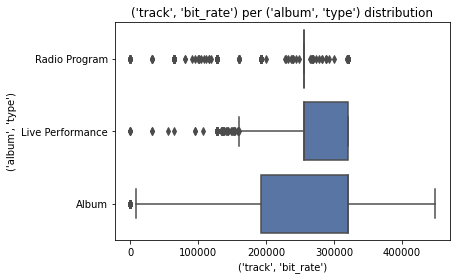

In [39]:
sns_boxplot_ordered_by_mean(tracks_filtered_album_types, ('album', 'type'), ('track', 'bit_rate'), "", True, True)

In [40]:
df_described_based_upon_genres(tracks_filtered_album_types, ('track', 'bit_rate'), ('album', 'type'),
                               tracks_filtered_album_types[('album', 'type')].dropna().unique())

Album min=-1 max=448000 mean=266790.3832688599 std=67848.19844177086 median=320000.0
Live Performance min=-1 max=320000 mean=255464.95590863953 std=56513.495215780866 median=256000.0
Radio Program min=-1 max=320592 mean=234464.5728007318 std=57944.50004793372 median=256000.0


According with bit_rate, album type:
- Album's tracks have an higher bit_rate (median 320000);
- Live Performance's and Radio Program's tracks have a similar bit_rate (both medians equal to 256000). However, Radio Program tend to have scattered bit_rate distribution than Live Performance.

PREPROCESSING: All three album types show missing bit_rates (-1).

<h6> Album duration insight </h6>

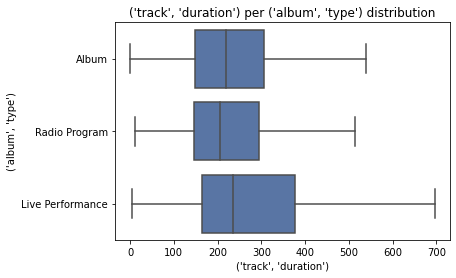

In [41]:
sns_boxplot_ordered_by_mean(tracks_filtered_album_types, ('album', 'type'), ('track', 'duration'), "", True, False)

In [42]:
df_described_based_upon_genres(tracks_filtered_album_types, ('track', 'duration'), ('album', 'type'),
                               tracks_filtered_album_types[('album', 'type')].dropna().unique())

Album min=0 max=11030 mean=268.2293542387 std=265.6352508404297 median=218.0
Live Performance min=5 max=18350 mean=399.92293942403177 std=546.0871905895273 median=236.0
Radio Program min=11 max=3717 mean=314.25308736087817 std=424.17671759727517 median=206.0


According with duration, album type:
- Radio Program's tracks have the shortest duration (median 206);
- Album's tracks have a medium duration (median 218);
- Live Performance's tracks have the longuest duration (median 236).

PREPROCESSING: All three album types show tracks' duration bellow and above 30s and 720s.

<h6> Album track listens insight </h6>

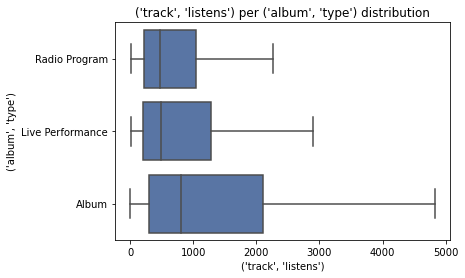

In [43]:
sns_boxplot_ordered_by_mean(tracks_filtered_album_types, ('album', 'type'), ('track', 'listens'), "", True, False)

In [44]:
df_described_based_upon_genres(tracks_filtered_album_types, ('track', 'listens'), ('album', 'type'),
                               tracks_filtered_album_types[('album', 'type')].dropna().unique())

Album min=1 max=543252 mean=2456.2430362991113 std=8608.33869424082 median=802.0
Live Performance min=9 max=63412 mean=1265.8430983118174 std=2631.1981766988074 median=491.0
Radio Program min=17 max=42936 mean=985.3724653148346 std=1826.1482865197788 median=481.0


According with listens, album type:
- Album's tracks are the most listened (median 802);
- Live Performance's  and Radio Program's tracks have similar listenings (median 491 and median 481).

PREPROCESSING: extreme, highe listens for albums of type "Album" 

<h6> Track album favorites insight </h6>

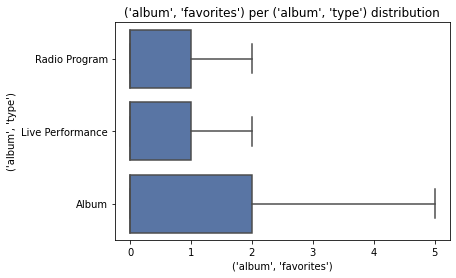

In [45]:
sns_boxplot_ordered_by_mean(tracks_filtered_album_types, ('album', 'type'), ('album', 'favorites'), "", True, False)

In [46]:
df_described_based_upon_genres(tracks_filtered_album_types, ('album', 'favorites'), ('album', 'type'),
                               tracks_filtered_album_types[('album', 'type')].dropna().unique())

Album min=0 max=61 mean=1.4368902125911471 std=3.2659372116510057 median=0.0
Live Performance min=0 max=13 mean=0.8087388282025819 std=1.5758416214718758 median=0.0
Radio Program min=0 max=9 mean=0.7623113279463333 std=1.2818937177269705 median=0.0


According with favorites, all three album types have a number of favorites similar (median=0), with, however, higher values for "Album" type. 

PREPROCESSING: extreme, highe favorites for albums of type "Album" 

<h6> Track artist favorites insight </h6>

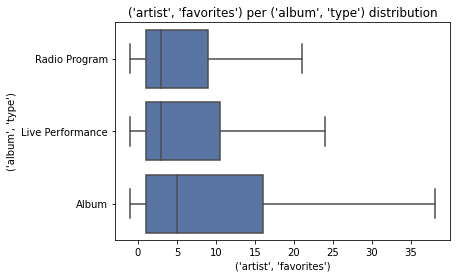

In [47]:
sns_boxplot_ordered_by_mean(tracks_filtered_album_types, ('album', 'type'), ('artist', 'favorites'), "", True, False)

In [48]:
df_described_based_upon_genres(tracks_filtered_album_types, ('artist', 'favorites'), ('album', 'type'),
                               tracks_filtered_album_types[('album', 'type')].dropna().unique())

Album min=-1 max=963 mean=31.786598655757533 std=105.82360214143262 median=5.0
Live Performance min=-1 max=199 mean=8.895928500496524 std=14.662332764353293 median=3.0
Radio Program min=-1 max=87 mean=7.770696752553743 std=11.583508325588506 median=3.0


According with artists' favorites, album type:
- Album's artists are the most liked (median 5);
- Live Performance's  and Radio Program's artists have similar favorite numbers (both median 3).

PREPROCESSING: extreme, highe artist favorites for albums of type "Album" 

<h6> Album year insight </h6>

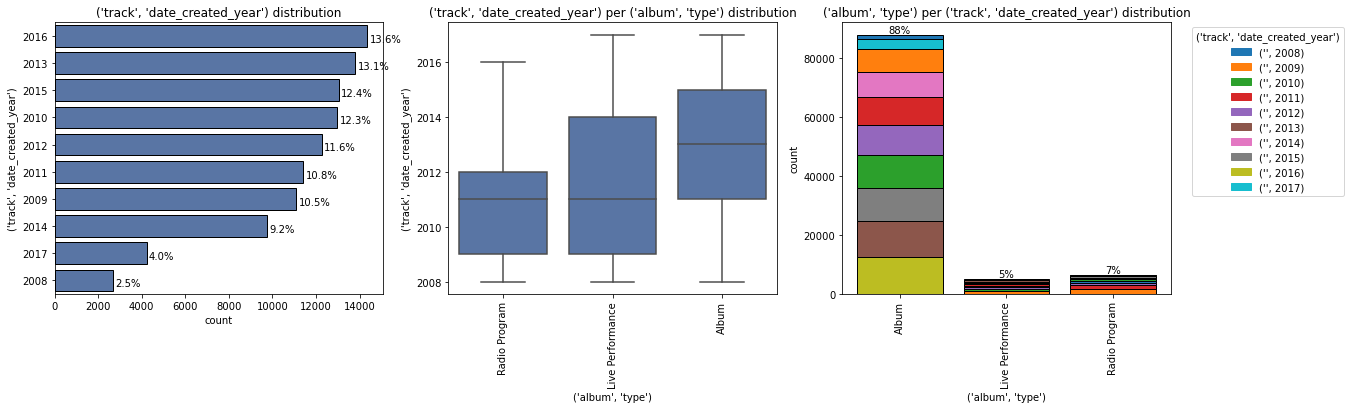

('track', 'date_created_year')'s max values:
Album	[(('', 2016), 12636)]	14.4%
Live Performance	[(('', 2009), 877)]	17.4%
Radio Program	[(('', 2009), 1729)]	26.4%


In [49]:
column_name1 = ('album', 'type')
column_name2 = ('track', 'date_created_year')
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns_countplot(tracks_filtered_album_types, column_name2, ax, False, True)
ax = plt.subplot2grid(fig_dims, (0, 1))
sns_boxplot_ordered_by_mean(tracks_filtered_album_types, column_name1, column_name2, ax, False, False)
ax = plt.subplot2grid(fig_dims, (0, 2))
pclass_xt = draw_reversed_frequency_stacked_bar(tracks_filtered_album_types, column_name1, column_name2, False, True, True, "")
plt.show()
# print_perc_column(tracks_filtered_album_types, column_name2)
# print_hues_perc_column(tracks_filtered_album_types, column_name2, column_name1)
# print_hues_all_perc_column(tracks_filtered_album_types, column_name2, column_name1)
# genre_zero_frequency_table_insight(pclass_xt,  tracks_filtered_album_types, column_name2, column_name1)
genre_max_frequency_table_insight(pclass_xt,  tracks_filtered_album_types, column_name2, column_name1)

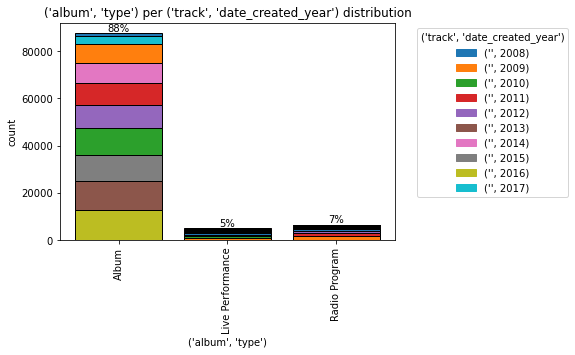

In [50]:
pclass_xt = draw_reversed_frequency_stacked_bar(tracks_filtered_album_types, ('album', 'type'), ('track', 'date_created_year'), False, True, True, "")

Predominantly, tracks were created:
- in 2016 for Albums (14.6%);
- in 2009 for Live Performance (16.9%) and Radio Program (26.4%).

All three album type are present in the range [2008-2017].

<h6>Albums' season insight</h6>

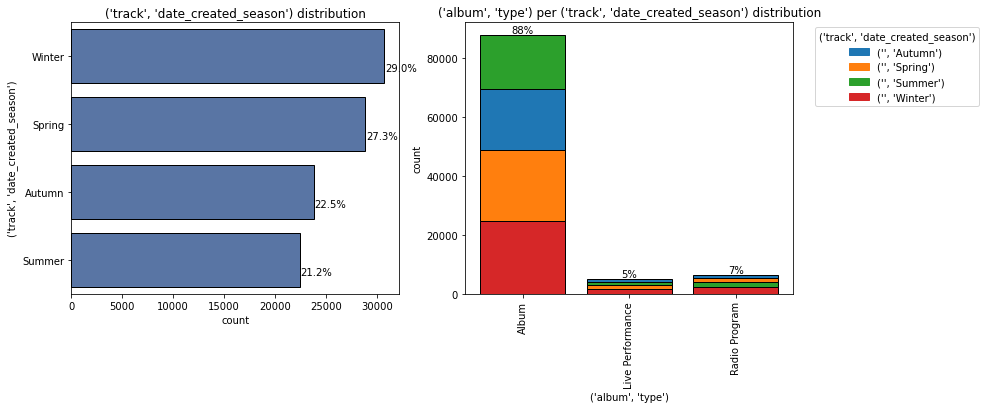

('track', 'date_created_season')'s zero values:
('track', 'date_created_season')'s max values:
Album	[(('', 'Winter'), 24668)]	28.1%
Live Performance	[(('', 'Winter'), 1857)]	36.9%
Radio Program	[(('', 'Winter'), 2350)]	35.8%


In [51]:
column_name1 = ('album', 'type')
column_name2 = ('track', 'date_created_season')
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns_countplot(tracks_filtered_album_types, column_name2, ax, False, True)
ax = plt.subplot2grid(fig_dims, (0, 1))
pclass_xt = draw_reversed_frequency_stacked_bar(tracks_filtered_album_types, column_name1, column_name2, False, True, True, "")
plt.show()
# print_perc_column(tracks_filtered_album_types, column_name2)
# print_hues_perc_column(tracks_filtered_album_types, column_name2, column_name1)
# print_hues_all_perc_column(tracks_filtered_album_types, column_name2, column_name1)
genre_zero_frequency_table_insight(pclass_xt,  tracks_filtered_album_types, column_name2, column_name1)
genre_max_frequency_table_insight(pclass_xt, tracks_filtered_album_types, column_name2, column_name1)

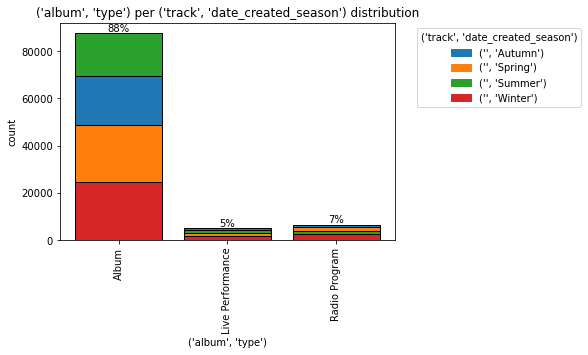

In [52]:
pclass_xt = draw_reversed_frequency_stacked_bar(tracks_filtered_album_types, ('album', 'type'), ('track', 'date_created_season'), False, True, True, "")

According with seasons' creation all three  recording type are mostly created in Winter:
- Album (28.1%);
- Live Performance (36.9%);
- Radio Program (35.8%).

All three album type are also present during all 4 seasons.

<h6> Albums' season insight </h6>

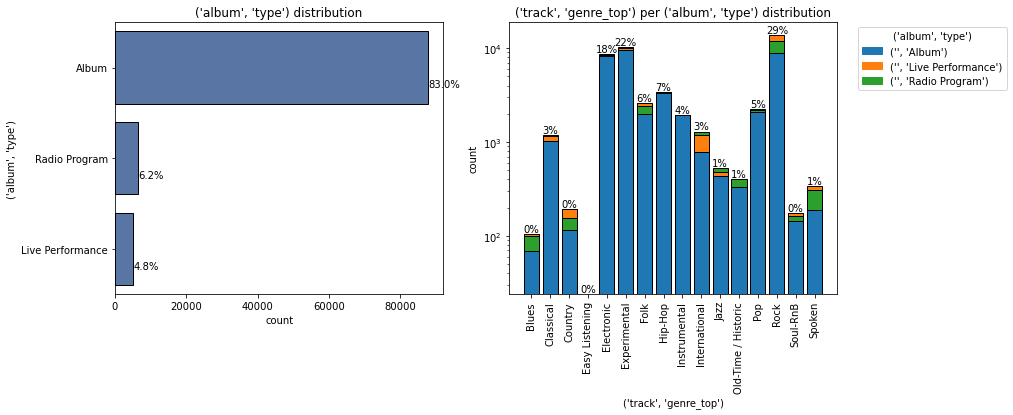

In [53]:
column_name1 = ('track', 'genre_top')
column_name2 = ('album', 'type')
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns_countplot(tracks_filtered_album_types, column_name2, ax, False, True)
ax = plt.subplot2grid(fig_dims, (0, 1))
pclass_xt = draw_reversed_frequency_stacked_bar(tracks_filtered_album_types, column_name1, column_name2,True, True, True, "")
plt.show()
# print_perc_column(tracks_filtered_album_types, column_name2)
# print_hues_perc_column(tracks_filtered_album_types, column_name2, column_name1)
# print_hues_all_perc_column(tracks_filtered_album_types, column_name2, column_name1)
# genre_zero_frequency_table_insight(pclass_xt, tracks_filtered_album_types, column_name2, column_name1)
# genre_max_frequency_table_insight(pclass_xt,  tracks_filtered_album_types, tracks_filtered_album_types, column_name1)

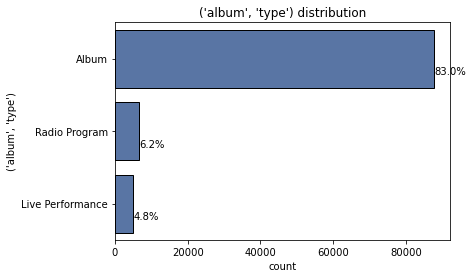

In [54]:
sns_countplot(tracks_filtered_album_types, ('album', 'type'), "", False, True)

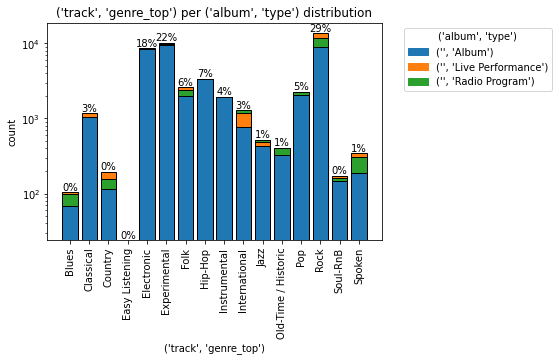

In [55]:
pclass_xt = draw_reversed_frequency_stacked_bar(tracks_filtered_album_types, ('track', 'genre_top'), ('album', 'type'), True, True, True, "")

In [56]:
column_name2 = ('track', 'genre_top')
column_name1 = ('album', 'type')
genre_zero_frequency_table_insight(pclass_xt, tracks_filtered_album_types, column_name2, column_name1)
print_hues_perc_column(tracks_filtered_album_types, column_name2, column_name1)

('track', 'genre_top')'s zero values:
('track', 'genre_top') per ('album', 'type'):
Album	Experimental	24.2%
Live Performance	Rock	53.7%
Radio Program	Rock	66.3%


Since Album type recordings are the most numerous in the dataset, it is natural to find most of genre_tops here.
According to the most present genre in each recording type:
- Album track's are usually Experimental (24.2%);
- Live Performance and Radio Program tracks are usually Rock (53.7%) and (66.3%).

We notice, finally, how Easy Listening and Old-Time / Historic aren't present in Live Perfomance and Easy Listening isn't present in Radio Program.

We decided to remove Contest album type, due to the presence of only 14 tracks in the dataset, while we proceeded in Single Tracks removal, too, since again only 917 records were present in the dataset, displaying higher audiance's appreciation (more listens, album and artist favorites), lower bit_rate and duration,  main Electronic genre presence, 2010 and autumn-time creation respect to Live Performance and Radio Program (instead, coherent among them and so merged together to enchance their presence).

<b><font color="green">
RECAP: 
- since Album is the most common type of recording, it is characterized by highest audience's likeness (higher number of tracks' listens, albums' and artists' favorites). They are also recognizable by higher tracks' higher bit_rate, medium duration, release in more recent years, preferably during the winter time and Experimental genre presence;
- Live Performance and Radio Program recording types are, instead, different from Albums. They are, indeed, quite similar among them, since they both convey the idea real time recording. As a metter of fact, they are less appreciated by the audiance (lower number of tracks' listens, albums' and artists' favorites), with high regard due to the fact they are related to niches. However, they differ in tracks' bit_rate (Radio Programs tend to have less even bit_rate distributions, anyway in the same bit_rate range) and duration (Radio Programs usually have shortest lengths), sharing the most common creation year (2009), creation seasons (Winter) and Rock genre presence.
</font></b>

From this RECAP, we got the idea that we can sum up together Live Performance and Radio Program recording types, getting the new **Live Recording** ('album', 'type')'s class label, instead. Thus, if we decide to perform our classification using ('album', 'type') as target feature, we will get a binary classification:

- Album, and so a **Studio Recording**, as for clarity we renamed it;
- not Album (and so a Live Recording of some sort, disregarding each track's genre and so preserving most records in the dataset).

**N.B. Please notice that to detect an album's type, the classifier implicitly will first detect a given track's genre. Consequently, album type classification is a disguised track genre classification problem.**

N.B.B.: We could, furthermore, remove all genre_top having a frequency lower than a certain threshold (exactly as we had done for ('album', 'type) using a threshold of = 1%), thus making the dataset more consistent.

<h2> Merge-Filtered albums' type understanding </h2>

In [57]:
album_types = list(tracks[('album', 'type')].unique())
album_types.remove('Contest')
album_types.remove('Single Tracks')

# filter ('album', 'type') column
tracks_merged_album_types = tracks[tracks[('album', 'type')].isin(album_types)]
# merge ('album', 'type') column
cleanup_nums = {('album', 'type'):{"Album": "Studio Recording", 
                                   "Live Performance":"Live Recording",
                                   "Radio Program": "Live Recording"}}
# remap ('album', 'type') column           
tracks_merged_album_types = tracks_merged_album_types.replace(cleanup_nums)
print("('album', 'type')", tracks_merged_album_types[('album', 'type')].unique())
tracks_merged_album_types.shape

('album', 'type') ['Studio Recording' 'Live Recording' nan]


(105643, 47)

<h6> Album bit-rate insight </h6>

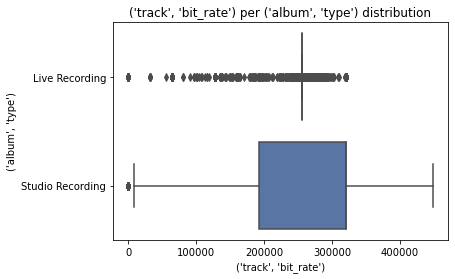

In [58]:
sns_boxplot_ordered_by_mean(tracks_merged_album_types, ('album', 'type'), ('track', 'bit_rate'), "", True, True)

In [59]:
df_described_based_upon_genres(tracks_merged_album_types, ('track', 'bit_rate'), ('album', 'type'),
                               tracks_merged_album_types[('album', 'type')].dropna().unique())

Studio Recording min=-1 max=448000 mean=266790.3832688599 std=67848.19844177086 median=320000.0
Live Recording min=-1 max=320592 mean=243584.54252199412 std=58262.438292542094 median=256000.0


According with bit_rate, album type:
- Album's tracks have an higher bit_rate (median 320000);
- LIve REcording's tracks has lower bit_rate (noth medians equal to 256000).

PREPROCESSING: All two album types show missing bit_rates (-1).

<h6> Album duration insight </h6>

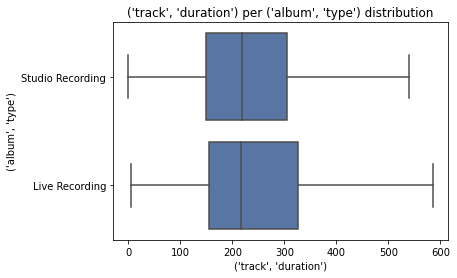

In [60]:
sns_boxplot_ordered_by_mean(tracks_merged_album_types, ('album', 'type'), ('track', 'duration'), "", True, False)

In [61]:
df_described_based_upon_genres(tracks_merged_album_types, ('track', 'duration'), ('album', 'type'),
                               tracks_merged_album_types[('album', 'type')].dropna().unique())

Studio Recording min=0 max=11030 mean=268.2293542387 std=265.6352508404297 median=218.0
Live Recording min=5 max=18350 mean=351.4574780058651 std=482.7798681222617 median=217.0


According with duration, Album (median 218) type and Live Performance (median 217) are similar

PREPROCESSING: All two album types show tracks' duration bellow and above 30s and 720s.

<h6> Album track listens insight </h6>

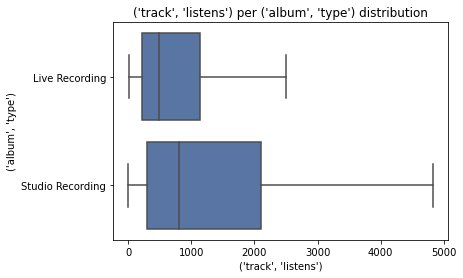

In [62]:
sns_boxplot_ordered_by_mean(tracks_merged_album_types, ('album', 'type'), ('track', 'listens'), "", True, False)

In [63]:
df_described_based_upon_genres(tracks_merged_album_types, ('track', 'listens'), ('album', 'type'),
                               tracks_merged_album_types[('album', 'type')].dropna().unique())

Studio Recording min=1 max=543252 mean=2456.2430362991113 std=8608.33869424082 median=802.0
Live Recording min=9 max=63412 mean=1107.174228048991 std=2216.3108781809383 median=486.0


According with listens, album type:
- Album's tracks are the most listened (median 802);
- Live Recording's  has lower listenings (median 486).

PREPROCESSING: extreme, highe listens for albums of type "Album" 

<h6> Track album favorites insight </h6>

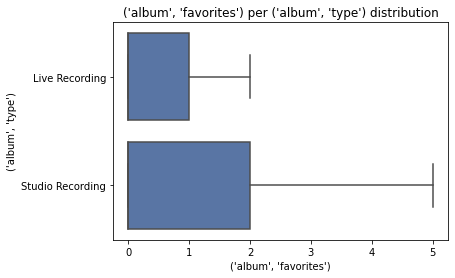

In [64]:
sns_boxplot_ordered_by_mean(tracks_merged_album_types, ('album', 'type'), ('album', 'favorites'), "", True, False)

In [65]:
df_described_based_upon_genres(tracks_merged_album_types, ('album', 'favorites'), ('album', 'type'),
                               tracks_merged_album_types[('album', 'type')].dropna().unique())

Studio Recording min=0 max=61 mean=1.4368902125911471 std=3.2659372116510057 median=0.0
Live Recording min=0 max=13 mean=0.7824736932896326 std=1.4171808302417757 median=0.0


According with favorites, all twp album types have a number of favorites similar (median=0), with, however, higher values for "Album" type. 

PREPROCESSING: extreme, highe favorites for albums of type "Album" 

<h6> Track artist favorites insight </h6>

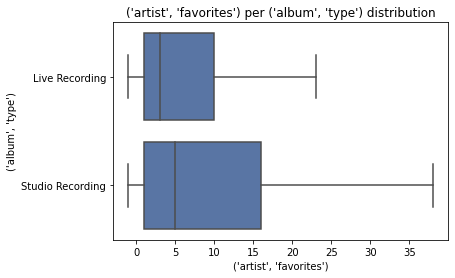

In [66]:
sns_boxplot_ordered_by_mean(tracks_merged_album_types, ('album', 'type'), ('artist', 'favorites'), "", True, False)

In [67]:
df_described_based_upon_genres(tracks_merged_album_types, ('artist', 'favorites'), ('album', 'type'),
                               tracks_merged_album_types[('album', 'type')].dropna().unique())

Studio Recording min=-1 max=963 mean=31.786598655757533 std=105.82360214143262 median=5.0
Live Recording min=-1 max=199 mean=8.259358288770054 std=13.021732723728658 median=3.0


According with artists' favorites, album type:
- Album's artists are the most liked (median 5);
- Live REcording's has lower favorite numbers (median 3).

PREPROCESSING: extreme, highe artist favorites for albums of type "Album" 

<h6> Album year insight </h6>

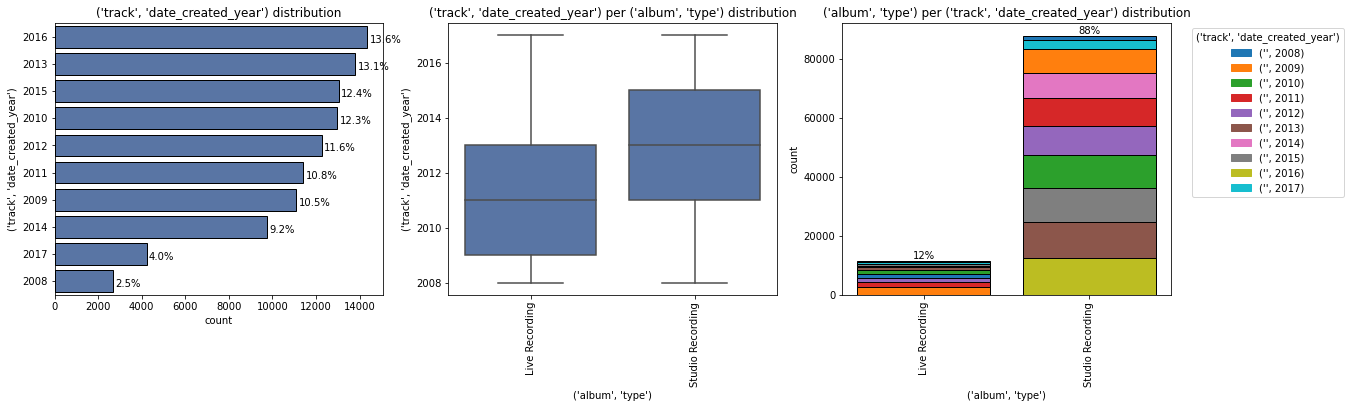

('track', 'date_created_year')'s max values:
Live Recording	[(('', 2009), 2606)]	22.5%
Studio Recording	[(('', 2016), 12636)]	14.4%


In [68]:
column_name1 = ('album', 'type')
column_name2 = ('track', 'date_created_year')
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns_countplot(tracks_merged_album_types, column_name2, ax, False, True)
ax = plt.subplot2grid(fig_dims, (0, 1))
sns_boxplot_ordered_by_mean(tracks_merged_album_types, column_name1, column_name2, ax, False, False)
ax = plt.subplot2grid(fig_dims, (0, 2))
pclass_xt = draw_reversed_frequency_stacked_bar(tracks_merged_album_types, column_name1, column_name2, False, True, True, "")
plt.show()
# print_perc_column(tracks_merged_album_types, column_name2)
# print_hues_perc_column(tracks_merged_album_types, column_name2, column_name1)
# print_hues_all_perc_column(tracks_merged_album_types, column_name2, column_name1)
# genre_zero_frequency_table_insight(pclass_xt,  tracks_merged_album_types, column_name2, column_name1)
genre_max_frequency_table_insight(pclass_xt,  tracks_merged_album_types, column_name2, column_name1)

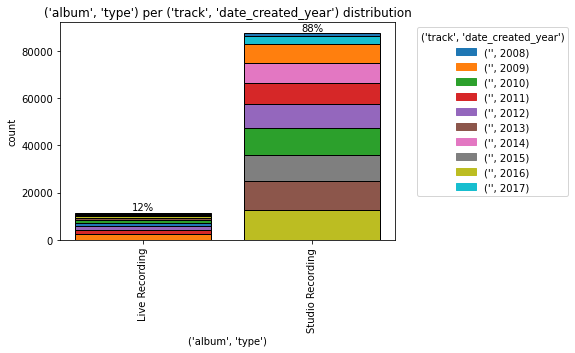

In [69]:
pclass_xt = draw_reversed_frequency_stacked_bar(tracks_merged_album_types, ('album', 'type'), ('track', 'date_created_year'), False, True, True, "")

In [70]:
df_described_based_upon_genres(tracks_merged_album_types, ('track', 'date_created_year'), ('album', 'type'),
                               tracks_merged_album_types[('album', 'type')].dropna().unique())

Studio Recording min=2008 max=2017 mean=2012.7835404470918 std=2.444222064969457 median=2013.0
Live Recording min=2008 max=2017 mean=2011.2587545282042 std=2.5902786299840947 median=2011.0


According with years' creation:
- Album's tracks are the most recent (median 2013);
- Live Recording's tracks are the most dated (median 2011).

Predominantly, tracks were created:
- in 2016 for Albums (14.6%);
- in 2009 for Live Recording (22.5%).

All three album type are present in the range [2008-2017].

<h6>Albums' season insight</h6>

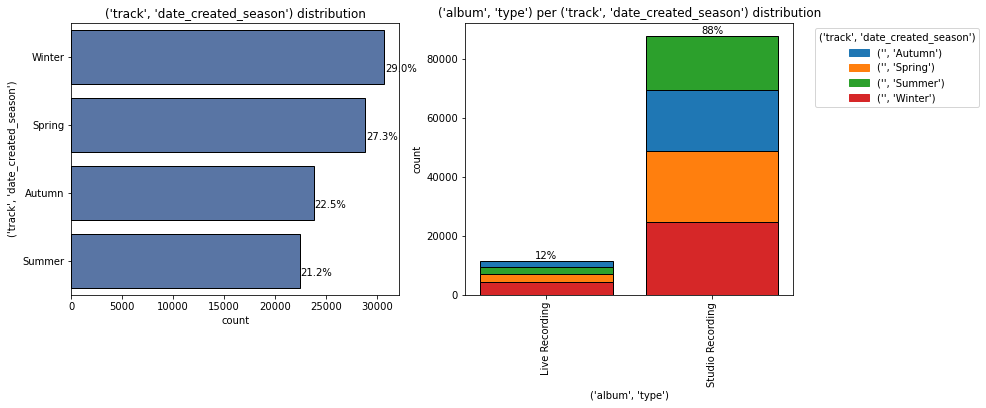

('track', 'date_created_season')'s max values:
Live Recording	[(('', 'Winter'), 4207)]	36.3%
Studio Recording	[(('', 'Winter'), 24668)]	28.1%


In [71]:
column_name1 = ('album', 'type')
column_name2 = ('track', 'date_created_season')
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns_countplot(tracks_merged_album_types, column_name2, ax, False, True)
ax = plt.subplot2grid(fig_dims, (0, 1))
pclass_xt = draw_reversed_frequency_stacked_bar(tracks_merged_album_types, column_name1, column_name2, False, True, True, "")
plt.show()
# print_perc_column(tracks_merged_album_types, column_name2)
# print_hues_perc_column(tracks_merged_album_types, column_name2, column_name1)
# print_hues_all_perc_column(tracks_merged_album_types, column_name2, column_name1)
# genre_zero_frequency_table_insight(pclass_xt,  tracks_merged_album_types, column_name2, column_name1)
genre_max_frequency_table_insight(pclass_xt, tracks_merged_album_types, column_name2, column_name1)

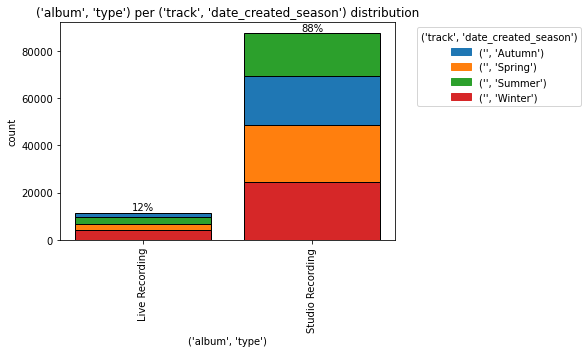

In [72]:
pclass_xt = draw_reversed_frequency_stacked_bar(tracks_merged_album_types, ('album', 'type'), ('track', 'date_created_season'), False, True, True, "")

According with seasons' creation all three  recording type are mostly created in Winter:
- Album (28.1%);
- Live Recording (36.3%).

All three album type are also present during all 4 seasons.

<h6> Albums' season insight </h6>

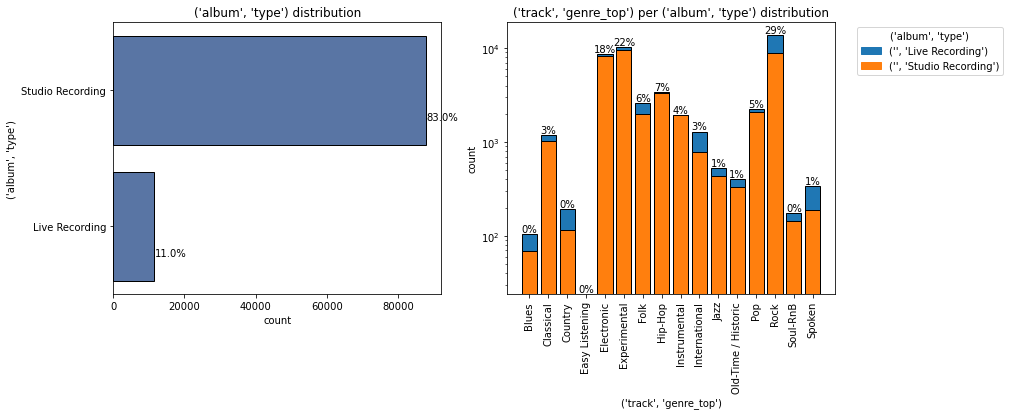

In [73]:
column_name1 = ('track', 'genre_top')
column_name2 = ('album', 'type')
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns_countplot(tracks_merged_album_types, column_name2, ax, False, True)
ax = plt.subplot2grid(fig_dims, (0, 1))
pclass_xt = draw_reversed_frequency_stacked_bar(tracks_merged_album_types, column_name1, column_name2,True, True, True, "")
plt.show()
# print_perc_column(tracks_merged_album_types, column_name2)
# print_hues_perc_column(tracks_merged_album_types, column_name2, column_name1)
# print_hues_all_perc_column(tracks_merged_album_types, column_name2, column_name1)
# genre_zero_frequency_table_insight(pclass_xt, tracks_merged_album_types, column_name2, column_name1)
# genre_max_frequency_table_insight(pclass_xt,  tracks_merged_album_types, tracks_filtered_album_types, column_name1)

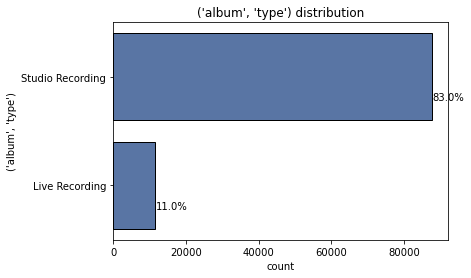

In [74]:
sns_countplot(tracks_merged_album_types, ('album', 'type'), "", False, True)

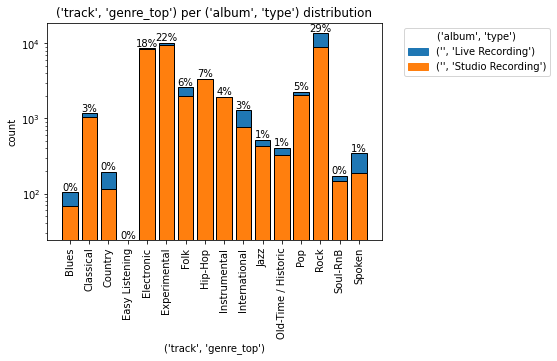

In [75]:
pclass_xt = draw_reversed_frequency_stacked_bar(tracks_merged_album_types, ('track', 'genre_top'), ('album', 'type'), True, True, True, "")

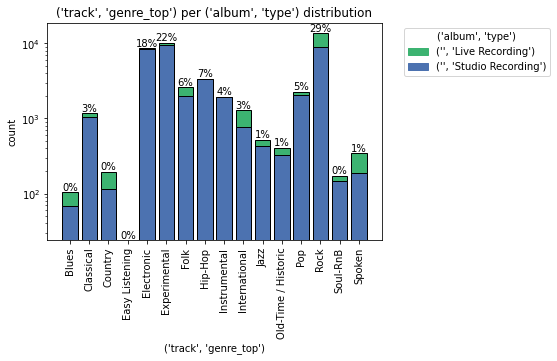

In [106]:
pclass_xt2 = draw_reversed_frequency_stacked_bar2(tracks_merged_album_types, ('track', 'genre_top'), ('album', 'type'), True, True, True, "")

In [2781]:
column_name2 = ('track', 'genre_top')
column_name1 = ('album', 'type')
genre_zero_frequency_table_insight(pclass_xt, tracks_merged_album_types, column_name2, column_name1)
print_hues_perc_column(tracks_merged_album_types, column_name2, column_name1)

('track', 'genre_top')'s zero values:
('track', 'genre_top') per ('album', 'type'):
Studio Recording	Experimental	24.2%
Live Recording	Rock	60.9%


Since Album type recordings are the most numerous in the dataset, it is natural to find most of genre_tops here.
According to the most present genre in each recording type:
- Album track's are usually Experimental (24.1%);
- Live Recording Rock (60.9%).

<b><font color="green">
RECAP: The differences among Album and Live Performance and Radio Program, gruopped together in LIve Recording, remain as above.
</font></b>

In [2782]:
# converting years to string
tracks[('track', 'date_created_year')] = tracks[('track', 'date_created_year')].astype(str)
tracks_filtered_album_types[('track', 'date_created_year')] = tracks_filtered_album_types[('track', 'date_created_year')].astype(str)
tracks_merged_album_types[('track', 'date_created_year')] = tracks_merged_album_types[('track', 'date_created_year')].astype(str)

<ipython-input-2782-1b1ab76e7b22>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_filtered_album_types[('track', 'date_created_year')] = tracks_filtered_album_types[('track', 'date_created_year')].astype(str)


<font color="orange"><h1>Imputation</h1></font>

In [2783]:
tracks_before_merging = tracks.copy()
tracks_before_imputation = tracks_merged_album_types.copy()
tracks = tracks_merged_album_types.copy()
tracks.shape

(105643, 47)

<font color="blue"><h3>Outlier removal</h3></font>

Since we will deal directly with sofisticated outlier methods, in the pre-processing phase we didn't cleaned the dataset using the InteQuartile Range Method (IQRM), but proceeded in removing solely extreme outliers by hand.  
Given the nature of our filtered features, we considered as outliers only tracks having a duration lower than 30 seconds, thus preventing the song to get a stream on Spotify and conseguently by the prior Echonest*. Live Performance and Radio Programs can last hours, so we didn't imposed an upper duration cutt-off. However, we removed the four, longuest tracks, since they were longer than 2 hours, while other tracks were less than one and a half hour. 

We performed a similar reasoning uppon track's bit_rate, this time imposing a lower cutt-off of 24.000 and upper cut-off of 41.6000, thus leading to 21 and 3 bit_rate outlier tracks removal, respectivelly.

Regarding ('track',   'listens'), ('artist', 'favorites') and ( 'album', 'favorites'), extreme values are justified by audiance's appreciation or not. However, we had to correct a track having set its listens to 0, by using other album track's listens mean.

By proceeding with our reasoned outlier removal, **we got rid of 1.918 records**.

*This assumptio was derivated from by some Spotify's FAQ, like https://community.spotify.com/t5/Accounts/When-and-how-does-Spotify-count-songs-as-quot-listened-to-quot/m-p/952243/highlight/true#M120586

In [2784]:
def get_interquartile_cut_off(data, k): 
    # calculate interquartile range
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    return q25, q75, cut_off, lower, upper

In [2785]:
echonestData = pd.read_csv('../../data/fma_metadata/echonest.csv',index_col=0, header=[0, 1, 2])
echonestData.shape

(13129, 249)

In [2786]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_tracks = filtered_tracks.select_dtypes(include=numerics)
del numeric_tracks[('album', 'id')]
del numeric_tracks[('artist', 'id')]
numeric_tracks.shape

(105643, 5)

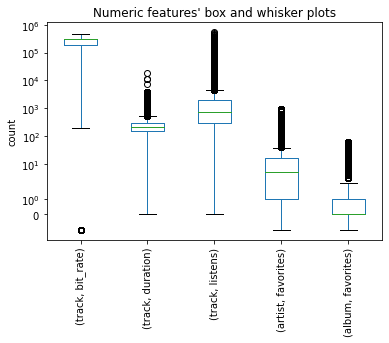

In [2787]:
# assess graphically outliers through box and whisker plots
boxplot = tracks.boxplot(column=list(numeric_tracks.columns), grid=False, rot=90)
plt.yscale("symlog")
plt.ylabel("count")
plt.title("Numeric features' box and whisker plots")
plt.show()

In [2788]:
# IQRM
outliers2 = set()
for column_name in numeric_tracks.columns:
    if column_name == ('album', 'favorites') or column_name == ('artist', 'favorites') or \
        column_name == ('track', 'listens'):
        continue
    data = tracks[tracks[(column_name)] != -1][column_name]  # omitting mising values 
    # get the outlier cutoff
    q25, q75, cut_off, lower, upper = get_interquartile_cut_off(data, 3.0)
    # identify outlier
    outliers = {}
    outliers["lower"] = []
    outliers["upper"] = []
    for x in data:
        if x < lower:
            tmp_list =  outliers["lower"]
            tmp_list.append(x)
            outliers["lower"] = tmp_list
            
        if x > upper:
            tmp_list =  outliers["upper"]
            tmp_list.append(x)
            outliers["upper"] = tmp_list

    tot_outliers = set(outliers["lower"]).union(set(outliers["upper"]))
    outliers2.update(tot_outliers)
    if len(tot_outliers) > 0: 
        print( '%s\'s percentiles: 25th=%.3f, 75th=%.3f, cut_off=%.3f, lower=%.3f, upper=%.3f, outliers: %d' 
                        % (column_name, q25, q75, cut_off, lower, upper, len(tot_outliers)))
        
        # lower_indexes = tracks[(tracks[column_name] != -1) & (tracks[column_name] < lower)].index
        # upper_indexes = tracksdf[(tracks[column_name] != -1) & (tracks[column_name] > upper)].index

print("outliers2", len(outliers2))

('track', 'duration')'s percentiles: 25th=150.000, 75th=306.000, cut_off=468.000, lower=-318.000, upper=774.000, outliers: 1465
outliers2 1465


In [2789]:
outliers = set()

In [2790]:
# first 10 longuest tracks
tracks[('track', 'duration')].nlargest(10)

track_id
2624      18350
122567    11030
108001    10999
112068     7372
39522      3718
112808     3718
44138      3717
62841      3717
43100      3716
9702       3714
Name: (track, duration), dtype: int64

In [2791]:
# removing 4 longuest tracks
outliers.update(tracks[(tracks[('track', 'duration')] >= 7372)].index)

In [2792]:
# To obtain an official stream on Spotify the track music be played for at least 30 seconds
# for a music creator to secure payment for a stream
# https://www.prsformusic.com/m-magazine/features/song-length-the-spotify-effect/#:~:text=To%20obtain%20an%20official%20stream,ranking%20within%20a%20streaming%20platform.
outliers.update(tracks[tracks[('track', 'duration')] < 30].index)
print(len(outliers))

1899


In [2793]:
# first 30 highest bit_rate
tracks[tracks[('track', 'bit_rate')] != -1][('track', 'bit_rate')].nsmallest(30)  # 21

track_id
9884        192
29345      8000
29346      8000
29352      8000
29356      8000
33411      8000
33413      8000
33414      8000
33417      8000
33418      8000
33419      8000
33425      8000
54569      8000
54582      8000
31373     24000
31375     24000
152009    24000
75324     31281
75320     31742
9151      32000
9153      32000
11583     32000
12852     32000
12855     32000
12856     32000
12883     32000
12899     32000
12918     32000
18556     32000
18643     32000
Name: (track, bit_rate), dtype: int64

In [2794]:
# first 10 highest bit_rate
tracks[tracks[('track', 'bit_rate')] != -1][('track', 'bit_rate')].nlargest(10)

track_id
36728    448000
65410    448000
32180    416000
70255    334914
96068    333035
51509    330042
70262    327887
51507    326464
96067    326255
94321    326000
Name: (track, bit_rate), dtype: int64

In [2795]:
# removing 21 highest bit_rate tracks
outliers.update(tracks[(tracks[('track', 'bit_rate')] != -1) &
                       (tracks[('track', 'bit_rate')] <= 24000)].index)
# removing 3 lower bit_rate tracks
outliers.update(tracks[(tracks[('track', 'bit_rate')] != -1) &
                       (tracks[('track', 'bit_rate')] >= 416000)].index)

In [2796]:
# first 10 less listened tracks
tracks[('track', 'listens')].nsmallest(10)

track_id
153867    0
150617    1
150621    1
154008    1
150618    2
150619    2
150624    2
150625    2
150627    2
150628    2
Name: (track, listens), dtype: int64

In [2797]:
# first 20 most listened tracks
tracks[('track', 'listens')].nlargest(20)

track_id
42377    543252
81466    491235
66053    468163
24425    433992
86599    429168
96534    400404
84990    374497
62460    356588
74724    349903
69170    335215
97154    332986
89034    325940
95976    299774
54159    294602
97146    262562
66542    250472
35033    249209
53835    235667
33936    226334
63807    221059
Name: (track, listens), dtype: int64

In [2798]:
# correct track never listened
album = tracks.at[153867, ('album', 'id')]
corrected_listens = round(tracks[(tracks[('album', 'id')] == album) &
                           (tracks[('track', 'listens')] != 0)][('track', 'listens')].mean())

tracks.at[153867, ('track', 'listens')] = corrected_listens

In [2799]:
# echonest comparison
len(outliers) - len(set(outliers).difference(set(echonestData.index)))

3

In [2800]:
# removing outlier from DataFrame
tracks.drop(list(outliers), axis=0, inplace=True)
print("dropped rows = ", len(outliers))

dropped rows =  1918


<font color="orange"><h3>('album', 'comments'), ('album', 'listens'), ('album', 'favorites'), ('album', 'tracks'), ('album', 'type'), ('artist', 'comments') and ('artist', 'favorites') imputation</h3></font>

For missing albums and artists' metadata, we impute missing values using given **album's or artist's other tracks' median or mode** (depending on the columns' data type), too (i.e. we replace ('album', 'comments')=-1 with 
other tracks having same ('album', 'id') but ('album', 'comments')!=-1 or if no other track was present in the same album we used median('album', 'comments') among M other artist's albums. For ('album', 'type') we imputed using matching ('album', 'id') but ('album', 'type')!=NaN type or by using the most frequent album type among M other artist's albums).

If no album's or artist's other tracks' are present, we use colum's median value as replacement, while for album's type we performed a majority vote uppon each median/mode features.

In [2801]:
def album_type_majority_vote(idx):
    numeric_columns = [('album', 'favorites'), ('artist', 'favorites'), ('track', 'listens'), 
                       ('track', 'duration'), ('track', 'bit_rate')]
    categoric_columns = [('track', 'date_created_year'), ('track', 'date_created_season'), ('track', 'genre_top')]
    
    type_dict = {"Live Recording": 0, "Studio Recording": 0}
    for column_name in numeric_columns:
        value = tracks.at[idx, column_name]
        lr = tracks[(tracks[('album', 'type')] == "Live Recording") &
                   (tracks[column_name] != -1)][column_name].median()
        sr = tracks[(tracks[('album', 'type')] == "Studio Recording") &
                    (tracks[column_name] != -1)][column_name].median()
        diff1 = abs(value - lr)
        diff2 = abs(value - sr)
        if diff1 < diff2:
            type_dict["Live Recording"] += 1
        elif diff1 > diff2: 
             type_dict["Studio Recording"] += 1
                
    for column_name in categoric_columns:
        value = tracks.at[idx, column_name]
        lr = tracks[(tracks[('album', 'type')] == "Live Recording")][column_name].mode()[0]
        sr = tracks[(tracks[('album', 'type')] == "Studio Recording")][column_name].mode()[0]
        if column_name[1] == 'date_created_year':
            diff1 = abs(int(value) - int(lr))
            diff2 = abs(int(value) - int(sr))
            if diff1 < diff2:
                type_dict["Live Recording"] += 1
            elif diff1 > diff2: 
                 type_dict["Studio Recording"] += 1
        else:
            if (value == lr) and (value != sr):
                type_dict["Live Recording"] += 1
            elif (value != lr) and (value == sr):
                 type_dict["Studio Recording"] += 1
    
    tmp_list = list(type_dict.keys())
    if tmp_list[0] > tmp_list[1]:
        return "Live Recording"
    elif tmp_list[0] <= tmp_list[1]:  # default type = Studio Recording
        return "Studio Recording"

In [2802]:
imputation_columns = [('album', 'comments'), ('album', 'listens'), ('album', 'favorites'), 
                      ('album', 'tracks'), ('album', 'type'), 
                      ('artist', 'comments'), ('artist', 'favorites')]

# missing values
for column_name in imputation_columns:
    if column_name[1] == 'type':
        print(column_name, tracks[tracks[column_name].isna()].shape[0])
    else:
          print(column_name, tracks[tracks[column_name] == -1].shape[0])

for column_name in imputation_columns:
    if column_name[1] == 'type':
        missing_album_indeces = tracks[tracks[column_name].isna()].index
    else:
        missing_album_indeces = tracks[tracks[column_name] == -1].index
    
    for idx in missing_album_indeces:
        album = tracks.at[idx, ('album', 'id')]
        artist = tracks.at[idx, ('artist', 'id')]
        if column_name[1] == 'type':
            tmp_df = tracks[(tracks[('album', 'id')] == album) & ~(tracks[column_name].isna())]
        else:
            tmp_df = tracks[(tracks[('album', 'id')] == album) & (tracks[column_name] != -1)]

        values = []
        if tmp_df.shape[0] > 0:
            values = list(tmp_df[column_name]) 
        else:
            if column_name[1] == 'type':
                tmp_df = tracks[(tracks[('artist', 'id')] == artist) & ~(tracks[column_name].isna())]
            else:
                tmp_df = tracks[(tracks[('artist', 'id')] == artist) & (tracks[column_name] != -1)]
            if tmp_df.shape[0] > 0:
                values = list(tmp_df[column_name])
            
        v = None
        if len(values) > 0: 
            if column_name[1] == 'type':                                                   
                # v = statistics.mode(values)
                v = album_type_majority_vote(idx)
            else:
                v = round(statistics.median(values))
                                                                         
        if v == None:
            if column_name[1] == 'type': 
                v = "Studio Recording"
            else:
                v = 0
        tracks.at[idx, column_name] = v

        
# checking
for column_name in imputation_columns:
    if column_name[1] == 'type':
        print(column_name, tracks[tracks[column_name].isna()].shape[0])
    else:
          print(column_name, tracks[tracks[column_name] == -1].shape[0])

('album', 'comments') 3364
('album', 'listens') 3364
('album', 'favorites') 3364
('album', 'tracks') 3364
('album', 'type') 6311
('artist', 'comments') 850
('artist', 'favorites') 850
('album', 'comments') 0
('album', 'listens') 0
('album', 'favorites') 0
('album', 'tracks') 0
('album', 'type') 0
('artist', 'comments') 0
('artist', 'favorites') 0


<font color="orange"><h3>('track', 'genre_top') imputation</h3></font>
To impute our target column ('track', 'genre_top') we use the following procedure:

1. we date back a given track's missing genre, by looking and evaluating ('track', 'genres') column. In particular, we performed a majority vote among the genres present in the list and if any ties were detected, we used the most frequent genre present in it to impute;
2. if a tie was present among ('track', 'genres') genres, we performed the majority vote upon ('track', 'genres_all'), which contains a superset of the tracks present in ('track', 'genres');
3. for tracks with ties among ('track', 'genres_all'), too, or with empty genre lists, we performed a majority vote uppon ('album', 'tags), ('artist', 'tags) and ('track', 'tags), taking into account matching tags reffering to the 163 total genres (re-mapped than in the usual 16 parent genres);
4. if all majority votes above failed, by taking into account that an album usually has a limited amout of genres, we tried to match tracks with missing genres to tracks without the same missing data and present in the same album, using as matching factors the same bit_rate;
5. for tracks being part of a single track album (and so being lonely in it), we performed the same reasoning, but this time using the same artist as tracks' grouping;
6. if all the above steps failed,we merged all genre_top suggested by the five processes and performed a majority vote uppon them. If again, a tie showed, using track's bit_rate and iterating over each genre involved in the tie, we used lowest difference among track's bit_rate and genre's bit_rate median value, to enact the genre tie solver (**Hypothesis: if a track's bit_rate is nearer to a genre_top A's median bit_rate than it is to a genre_top B's median bit_rate, is more probable that the track belongs to A than B**). We used median values, to mitigate bit_rate's outliers, but if the tie still persisted, we used mean values;
7. whereupon, if again a ties showed, enact the genre tie solver, using lowest difference among track's bit_rate  and 16 main genres' bit_rate mean value (we used directly the mean, since many genres shared the same median values). If, however, a track has bit_rate set to -1 (and so being a missing value), we prefered to discregard the particular record, thus preventing noise introduction in the dataset, since we would impute a missing record ([('track', 'genre_top')]) with another missing record [('track', 'bit_rate')].

In [2803]:
# loading DataFrame for genres' translation
genres_df = pd.read_csv("../../data/fma_metadata/genres.csv")
genres_df.shape

(163, 5)

In [2804]:
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   genre_id   163 non-null    int64 
 1   #tracks    163 non-null    int64 
 2   parent     163 non-null    int64 
 3   title      163 non-null    object
 4   top_level  163 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 6.5+ KB


<font color="orange"><h6>('track', 'genres') and ('track', 'genres_all') imputation</h6></font>

In [2805]:
def genres_all_remapping(genres_all):
    genres_all_mapped = []
    for g in genres_all:
        top_level = genres_df[genres_df["genre_id"] == int(g)]["top_level"].values[0]
        title = genres_df[genres_df["genre_id"] == int(top_level)]["title"].values[0]
        genres_all_mapped.append(title)
    return genres_all_mapped

In [2806]:
def genres_all_majority_vote_imputation(column_name):
    no_genres_all = []
    remaining_ties = []
    solved_ties = {}
    missing_genre_indeces = tracks[tracks[('track', 'genre_top')].isna()].index
    for idx in missing_genre_indeces:
        genres_all = tracks.at[idx, column_name].strip('][').split(', ') # converting str to list
        if len(genres_all) > 0 and genres_all[0] != '':
            genres_all_mapped = genres_all_remapping(genres_all)
            genres_all_mapped_counter = Counter(genres_all_mapped)
            # decreasing genres' frequency in list [MAJORITY VOTE]
            sorted_genres_all_mapped_counter = dict(sorted(genres_all_mapped_counter.items(), 
                                                                   key=lambda item: item[1], reverse=True))
            first_k, second_k =  itertools.islice(sorted_genres_all_mapped_counter.keys(), 2)
            first_v, second_v =  itertools.islice(sorted_genres_all_mapped_counter.values(), 2)
            if first_v == second_v:
                remaining_ties.append(idx)
            elif first_v < second_v:
                print("should not happen")
                sys.exit(-1)
            else: # first_v > second_v
                solved_ties[idx] = first_k
        else:
            no_genres_all.append(idx)
            
    print("solved_ties", len(solved_ties))
    print("remaining_ties", len(remaining_ties))
    print("no_genres_all", len(no_genres_all))

    return solved_ties, remaining_ties, no_genres_all

In [2807]:
def retrieve_divercences_among_dicts(dict1, dict2):
    divergences = []
    same_solved_ties = set(dict1.keys()).intersection(set(dict2.keys()))
    print("same_solved_ties", len(same_solved_ties))

    for key in same_solved_ties:
        if dict1[key] != dict2[key]:
            divergences.append(key)
    print("divergences", len(divergences))
    return divergences

In [2808]:
def evaluating_divergences(divergences):
    for key in divergences:
        genres_all_mapped = genres_all_remapping(tracks.at[key, ('track', 'genres_all')].strip('][').split(', '))
        genres_all_mapped_counter = Counter(genres_all_mapped)
        sorted_genres_all_mapped_counter = dict(sorted(genres_all_mapped_counter.items(), key=lambda item: item[1], reverse=True))

        genres_mapped = genres_all_remapping(tracks.at[key, ('track', 'genres')].strip('][').split(', '))
        genres_mapped_counter = Counter(genres_mapped)
        sorted_genres_mapped_counter = dict(sorted(genres_mapped_counter.items(), key=lambda item: item[1], reverse=True))

        print(sorted_genres_all_mapped_counter, sorted_genres_mapped_counter)
        print(solved_ties[key], solved_ties2[key])

In [2809]:
# checking if ('track', 'genre_top') is based uppon ('track', 'genres') or 
# ('track', 'genres_all') MAJORITY VOTE
tracks_with_genre_top = tracks[~(tracks[('track', 'genre_top')].isna())]

check_dict = {}  # key=genres_all or genres values=[idx]
check_dict["genres"] = []
check_dict["genres_all"] = []
for idx in tracks_with_genre_top.index:
    genre_top = tracks.at[idx, ('track', 'genre_top')]
    genres = tracks.at[idx, ('track', 'genres')].strip('][').split(', ') # converting str to list
    genres_all = tracks.at[idx, ('track', 'genres_all')].strip('][').split(', ') # converting str to list
    
    genres_MAJORITY_VOTE = None
    if len(genres) > 0:
        genres_mapped = genres_all_remapping(genres)
        genres_mapped_counter = Counter(genres_mapped)
        # decreasing genres' frequency in list [MAJORITY VOTE]
        sorted_genres_mapped_counter = dict(sorted(genres_mapped_counter.items(), 
                                                               key=lambda item: item[1], reverse=True))
        if len(sorted_genres_mapped_counter) == 1:
            genres_MAJORITY_VOTE = genres_mapped[0]
        else:
            first_k, second_k =  itertools.islice(sorted_genres_mapped_counter.keys(), 2)
            first_v, second_v =  itertools.islice(sorted_genres_mapped_counter.values(), 2)
            if first_v == second_v:
                pass
            elif first_v < second_v:
                print("should not happen")
                sys.exit(-1)
            else: # first_v > second_v
                genres_MAJORITY_VOTE = first_k
         
    genres_all_MAJORITY_VOTE = None
    if len(genres_all) > 1:
        genres_all_mapped = genres_all_remapping(genres_all)
        genres_all_mapped_counter = Counter(genres_all_mapped)
        # decreasing genres' frequency in list [MAJORITY VOTE]
        sorted_genres_all_mapped_counter = dict(sorted(genres_all_mapped_counter.items(), 
                                                               key=lambda item: item[1], reverse=True))
        if len(sorted_genres_all_mapped_counter) == 1:
            genres_all_MAJORITY_VOTE = genres_mapped[0]
        else:
            first_k, second_k =  itertools.islice(sorted_genres_all_mapped_counter.keys(), 2)
            first_v, second_v =  itertools.islice(sorted_genres_all_mapped_counter.values(), 2)
            if first_v == second_v:
                pass
            elif first_v < second_v:
                print("should not happen")
                sys.exit(-1)
            else: # first_v > second_v
                genres_all_MAJORITY_VOTE = first_k
            
    check_genres = (genre_top == genres_MAJORITY_VOTE)
    if check_genres:
        check_dict["genres"].append(idx)
     
    check_all_genres = (genre_top == genres_all_MAJORITY_VOTE)
    if check_all_genres:
        check_dict["genres_all"].append(idx)
            
print("tracks_with_genre_top", tracks_with_genre_top.shape[0])
print("genres", len(check_dict["genres"]))
print("genres_all", len(check_dict["genres_all"]))

tracks_with_genre_top 48007
genres 48007
genres_all 35344


In [2810]:
# imputation based uppon ('track', 'genres') majority vote
solved_ties, remaining_ties, no_genres_all = genres_all_majority_vote_imputation(('track', 'genres'))
print()
# imputation based uppon ('track', 'genres_all') majority vote
solved_ties2, remaining_ties2, no_genres_all2 = genres_all_majority_vote_imputation(('track', 'genres_all'))

solved_ties 25826
remaining_ties 27823
no_genres_all 2069

solved_ties 30405
remaining_ties 23244
no_genres_all 2069


In [2811]:
# checking if ('track', 'genres') and ('track', 'genres_all') solved tracks' missing genre_top at the same way
divergences = retrieve_divercences_among_dicts(solved_ties, solved_ties2)
print()
# evaluating divergences
# evaluating_divergences(divergences)

same_solved_ties 18747
divergences 434



In [2812]:
additional_solved_ties = set(solved_ties2.keys()).difference(solved_ties.keys())
for key in additional_solved_ties:
    solved_ties[key] = solved_ties2[key]
missing_genre_indeces = tracks[tracks[('track', 'genre_top')].isna()].index
tmp_set = set(missing_genre_indeces).difference(set(solved_ties.keys()))
remaining_ties = list(tmp_set.difference(set(no_genres_all)))
print("solved_ties", len(solved_ties))
print("remaining_ties", len(remaining_ties))
print("no_genres_all", len(no_genres_all))

total_lenght = len(solved_ties) + len(remaining_ties) + len(no_genres_all)
if total_lenght != tracks[tracks[('track', 'genre_top')].isna()].shape[0]:
    print("Some idx computation went wrong")
    sys.exit(-1)

solved_ties 37484
remaining_ties 16165
no_genres_all 2069


**Using ('track', 'genres') feature, we are able to impute 46.25% of ('track', 'genre_top')'s missing values.
This number further raises to 67.24% using ('track', 'genres_all') feature to solve ('track', 'genres')'s ties**.


PREPROCESSING: We detect also that 2.231 tracks don't have any genres information, so if they won't display some other imputation traits, they will be discarded, since we aren't able to impute them confidently.

<font color="orange"><h6>same ('album', 'id') and ('track', 'bit_rate') and ('artist', 'id') and ('track', 'bit_rate') imputation </h6></font>

In [2813]:
def genres_bit_rate_imputation(column_name, missing_genre_indeces):
    curr_solved_ties = {}
    curr_missing_bit_rates = []
    curr_remaining_ties = []
    curr_missing_genre_indeces = []
    for idx in missing_genre_indeces:
        aid = tracks.at[idx, column_name]
        bit_rate = tracks.at[idx, ('track', 'bit_rate')]
        if bit_rate == -1:
            curr_missing_bit_rates.append(idx)
            continue
        # remove NaN genre_top (including current track) from majority vote
        values = tracks[(tracks[column_name] == aid) &
                        (tracks[('track','bit_rate')] != -1) & 
                        (tracks[('track','bit_rate')] == bit_rate)][('track', 'genre_top')].dropna()  
        values_counter = Counter(values)
        if len(values_counter) > 1:  # majority vote
            sorted_values_counter = dict(sorted(values_counter.items(), key=lambda item: item[1], reverse=True))
            first_k, second_k =  itertools.islice(sorted_values_counter.keys(), 2)
            first_v, second_v =  itertools.islice(sorted_values_counter.values(), 2)
            if first_v == second_v:  # tie
                curr_remaining_ties.append(idx)
            elif first_v < second_v:
                print("should not happen")
                sys.exit(-1)
            else: # first_v > second_v
                curr_solved_ties[idx] = first_k
        elif len(values_counter) == 1:  # one vote
            first_k = next(iter(values_counter.keys()))
            curr_solved_ties[idx] = first_k
        else:  # no vote (no matching bit_rate)
            curr_missing_genre_indeces.append(idx)

    print("curr_solved_ties", len(curr_solved_ties))
    print("curr_remaining_ties", len(curr_remaining_ties))
    print("curr_missing_bit_rates", len(curr_missing_bit_rates))
    print("curr_missing_genre_indeces", len(curr_missing_genre_indeces))
    return curr_solved_ties, curr_remaining_ties, curr_missing_bit_rates, curr_missing_genre_indeces

In [2814]:
# imputation based uppon same ('album', 'id') and ('track', 'bit_rate')
missing_genre_indeces = list(set(remaining_ties).union(set(no_genres_all)))
print("missing_genre_indeces", len(missing_genre_indeces))
curr_solved_ties, curr_remaining_ties, curr_missing_bit_rates, curr_missing_genre_indeces = \
                                                genres_bit_rate_imputation(('album', 'id'), missing_genre_indeces)

missing_genre_indeces 18234
curr_solved_ties 622
curr_remaining_ties 69
curr_missing_bit_rates 31
curr_missing_genre_indeces 17512


In [2815]:
# imputation based uppon same ('artist', 'id') ('track', 'bit_rate') 
missing_genre_indeces = list(set(curr_missing_genre_indeces).union(set(curr_remaining_ties)))
curr_solved_ties2, curr_remaining_ties2, curr_missing_bit_rates2, curr_missing_genre_indeces2 = \
                                                genres_bit_rate_imputation(('artist', 'id'), missing_genre_indeces)

curr_solved_ties 3927
curr_remaining_ties 110
curr_missing_bit_rates 0
curr_missing_genre_indeces 13544


In [2816]:
# checking if ('album', 'id') and ('track', 'genres_all/genres') solved tracks' missing genre_top at the same way
divergences = retrieve_divercences_among_dicts(solved_ties, curr_solved_ties)
print()

same_solved_ties 0
divergences 0



In [2817]:
# checking if ('artist', 'id') and ('track', 'genres_all/genres') solved tracks' missing genre_top at the same way
divergences = retrieve_divercences_among_dicts(solved_ties, curr_solved_ties2)
print()

same_solved_ties 0
divergences 0



In [2818]:
# checking if ('album', 'id') and ('artist', 'id') solved tracks' missing genre_top at the same way
divergences = retrieve_divercences_among_dicts(curr_solved_ties, curr_solved_ties2)
print()

same_solved_ties 0
divergences 0



In [2819]:
additional_solved_ties = set(curr_solved_ties.keys()).union(curr_solved_ties2.keys())
len(additional_solved_ties)

4549

In [2820]:
for key in curr_solved_ties.keys():
    solved_ties[key] = curr_solved_ties[key]
for key in curr_solved_ties2.keys():
    solved_ties[key] = curr_solved_ties2[key]
    
missing_genre_indeces = tracks[tracks[('track', 'genre_top')].isna()].index
remaining_ties = list(set(missing_genre_indeces).difference(set(solved_ties.keys())))  
print("solved_ties", len(solved_ties))
print("remaining_ties", len(remaining_ties))

total_lenght = len(solved_ties) + len(remaining_ties) 
if total_lenght != tracks[tracks[('track', 'genre_top')].isna()].shape[0]:
    print("Some idx computation went wrong")
    sys.exit(-1)

solved_ties 42033
remaining_ties 13685


**Using match ('album', 'id')'s or ('artist', 'id')'s ('track', 'bit_rate'), we are able to raise up to 75.66% of ('track', 'genre_top')'s missing values**.

In [2821]:
# imputing ('track', 'genre_top') using ('track', 'tags'), ('album', 'tags'), ('artist', 'tags')
tags_solved_ties = {}
tags_remaining_ties = set()
all_163_genres = list(genres_df["title"].dropna().unique())
for idx in remaining_ties:
    
    values_counter = {}
    tags_columns = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags')]
    for tag_column in tags_columns:
        tags = tracks.at[idx, tag_column].strip('][').split(', ')

        for t in tags:
            t = t.replace("\'", "").title()
            if t in all_163_genres:
                top_level = genres_df[genres_df["title"] == t]["top_level"].values[0]
                title = genres_df[genres_df["genre_id"] == top_level]["title"].values[0]
                try:
                    values_counter[title] += 1
                except KeyError:
                    values_counter[title] = 1
                
    if len(values_counter) > 1:  # majority vote
        sorted_values_counter = dict(sorted(values_counter.items(), key=lambda item: item[1], reverse=True))
        first_k, second_k =  itertools.islice(sorted_values_counter.keys(), 2)
        first_v, second_v =  itertools.islice(sorted_values_counter.values(), 2)
        
        if first_v == second_v:  # tie
            tags_remaining_ties.add(idx)
        elif first_v < second_v:
            print("should not happen")
            sys.exit(-1)
        else: # first_v > second_v
            tags_solved_ties[idx] = first_k
    elif len(values_counter) == 1:  # one vote
        first_k = next(iter(values_counter.keys()))
        tags_solved_ties[idx] = first_k
    else:
        tags_remaining_ties.add(idx)
            
print("tags_solved_ties", len(tags_solved_ties))          
print("tags_remaining_ties", len(tags_remaining_ties))

tags_solved_ties 2149
tags_remaining_ties 11536


In [2822]:
# checking if ('album', 'id') and ('track/album/artist', 'tags') solved tracks' missing genre_top at the same way
divergences = retrieve_divercences_among_dicts(tags_solved_ties, curr_solved_ties)
print()

same_solved_ties 0
divergences 0



In [2823]:
# checking if ('album', 'id') and 'track/album/artist', 'tags') solved tracks' missing genre_top at the same way
divergences = retrieve_divercences_among_dicts(tags_solved_ties, curr_solved_ties2)
print()

same_solved_ties 0
divergences 0



In [2824]:
for key in tags_solved_ties.keys():
    solved_ties[key] = tags_solved_ties[key]
    
missing_genre_indeces = tracks[tracks[('track', 'genre_top')].isna()].index
remaining_ties = list(set(missing_genre_indeces).difference(set(solved_ties.keys())))  
print("solved_ties", len(solved_ties))
print("remaining_ties", len(remaining_ties))

total_lenght = len(solved_ties) + len(remaining_ties) 
if total_lenght != tracks[tracks[('track', 'genre_top')].isna()].shape[0]:
    print("Some idx computation went wrong")
    sys.exit(-1)

solved_ties 44182
remaining_ties 11536


**Using match ('track', 'tags'), ('album', 'tags') and ('album', 'tags') , we are able to raise up to 80.67% of ('track', 'genre_top')'s missing values.**

In [2825]:
# solving ties using all previous 5 processes together

def forced_tie_solving(median_or_mean_flag):
    forced_genre_top_info = {}
    missing_genre_top_info = []
    for idx in remaining_ties:
        values_counter = {}

        album = tracks.at[idx, ('album', 'id')]
        artist = tracks.at[idx, ('artist', 'id')]
        bit_rate = tracks.at[idx, ('track', 'bit_rate')]
        genres = tracks.at[idx, ('track', 'genres')].strip('][').split(', ')
        genres_all = tracks.at[idx, ('track', 'genres_all')].strip('][').split(', ')

        genres_flag = True
        if len(genres) == 0 or (len(genres) == 1 and genres[0] == ''):
            genres_flag = False

        genres_all_flag = True
        if len(genres_all) == 0 or (len(genres_all) == 1 and genres_all[0] == ''):
            genres_all_flag = False

        if genres_flag:
            genres_remapped = genres_all_remapping(genres)
            for g in genres_remapped:
                try:
                    values_counter[g] += 1
                except KeyError:
                    values_counter[g] = 1

        if genres_all_flag:
            genres_all_remapped = genres_all_remapping(genres_all)
            for g in genres_all_remapped:
                try:
                    values_counter[g] += 1
                except KeyError:
                    values_counter[g] = 1

        if bit_rate != -1:
            tmp_list = tracks[(tracks[('album', 'id')] == album) &
                      (tracks[('track', 'bit_rate')] != -1) & 
                     (tracks[('track', 'bit_rate')] == bit_rate)][('track', 'genre_top')].dropna().values
            for g in tmp_list:
                try:
                    values_counter[g] += 1
                except KeyError:
                    values_counter[g] = 1

            tmp_list2 = tracks[(tracks[('artist', 'id')] == artist) &
                      (tracks[('track', 'bit_rate')] != -1) & 
                     (tracks[('track', 'bit_rate')] == bit_rate)][('track', 'genre_top')].dropna().values

            for g in tmp_list2:
                try:
                    values_counter[g] += 1
                except KeyError:
                    values_counter[g] = 1

        tags_columns = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags')]
        for tag_column in tags_columns:
            tags = tracks.at[idx, tag_column].strip('][').split(', ')

            for t in tags:
                t = t.replace("\'", "").title()
                if t in all_163_genres:
                    top_level = genres_df[genres_df["title"] == t]["top_level"].values[0]
                    title = genres_df[genres_df["genre_id"] == top_level]["title"].values[0]
                    try:
                        values_counter[title] += 1
                    except KeyError:
                        values_counter[title] = 1

        if len(values_counter) > 0:
            values = list(values_counter.values())
            all_same_values = all(x == values[0] for x in values)

             # removing lowest frequency genre_top from dict and 
            # keeping only most frequent ties
            while(all_same_values == False):
                min_key = min(values_counter.keys(), key=lambda k: values_counter[k])
                del values_counter[min_key]

                values = list(values_counter.values())
                all_same_values = all(x == values[0] for x in values)

            if len(values_counter) == 0:
                print(idx)
                sys.exit(-1)
            elif len(values_counter) == 1:  # solved tie
                first_k = next(iter(values_counter.keys()))
                forced_genre_top_info[idx] = first_k
            else:  # tie
                min_diff_keys = set()
                min_diff_value = sys.maxsize
                for key, valeu in values_counter.items():
                    if median_or_mean_flag == "median":
                        key_mean = tracks[(tracks[('track', 'genre_top')] == key) & 
                                         (tracks[('track', 'bit_rate')] != -1)][('track', 'bit_rate')].median()
                    elif median_or_mean_flag == "mean":
                        key_mean = tracks[(tracks[('track', 'genre_top')] == key) & 
                                         (tracks[('track', 'bit_rate')] != -1)][('track', 'bit_rate')].mean()
                    else:
                        print("wrong median_or_mean_flag")
                        sys.exit(-1)
                    diff = abs(bit_rate - key_mean)
                    if diff < min_diff_value:
                        min_diff_keys.add(key)
                        min_diff_value = diff
                    elif diff == min_diff_value:
                        min_diff_keys.add(key)

                if len(min_diff_keys) == 1:
                    forced_genre_top_info[idx] = list(min_diff_keys)[0]
                else:
                    missing_genre_top_info.append(idx)
        else:
            missing_genre_top_info.append(idx)

    print("forced_genre_top_info", len(forced_genre_top_info))
    print("missing_genre_top_info", len(missing_genre_top_info))
    
    return forced_genre_top_info, missing_genre_top_info

In [2826]:
# median tie solver
median_forced_genre_top_info, median_missing_genre_top_info = forced_tie_solving("median")

forced_genre_top_info 2257
missing_genre_top_info 9279


In [2827]:
# mean tie solver
mean_forced_genre_top_info, mean_missing_genre_top_info = forced_tie_solving("mean")

forced_genre_top_info 4811
missing_genre_top_info 6725


In [2828]:
# checking if median and mean forced ties solving,  solved tracks' missing genre_top at the same way
divergences = retrieve_divercences_among_dicts(median_forced_genre_top_info, mean_forced_genre_top_info)
print()

same_solved_ties 2075
divergences 0



In [2829]:
for key in median_forced_genre_top_info.keys():
    solved_ties[key] = median_forced_genre_top_info[key]
    
for key in mean_forced_genre_top_info.keys():
    solved_ties[key] = mean_forced_genre_top_info[key]
    
missing_genre_indeces = tracks[tracks[('track', 'genre_top')].isna()].index
remaining_ties = list(set(missing_genre_indeces).difference(set(solved_ties.keys())))  
print("solved_ties", len(solved_ties))
print("remaining_ties", len(remaining_ties))

total_lenght = len(solved_ties) + len(remaining_ties) 
if total_lenght != tracks[tracks[('track', 'genre_top')].isna()].shape[0]:
    print("Some idx computation went wrong")
    sys.exit(-1)

solved_ties 49175
remaining_ties 6543


**Using our median/mode tie solving process, we are able to raise up to 88.72% of ('track', 'genre_top')'s missing values.**

In [2830]:
def get_nearest_genre_top_bit_rate(bit_rate):
    """
        We use mean(), since too many genre_top have the same median() bit_rate
    """
    genres = list(tracks[('track', 'genre_top')].dropna().unique())
    genres_bit_rate_diff_dict = {}
    for g in genres:
        mean_bit_rate = tracks[(tracks[('track', 'genre_top')] == g) & 
                              (tracks[('track', 'bit_rate')] != -1)][('track', 'bit_rate')].mean()
        diff = abs(bit_rate - mean_bit_rate)
        genres_bit_rate_diff_dict[g] = diff

    values = list(genres_bit_rate_diff_dict.values())
    if len(values) > len(set(values)):
        print("tie", idx, genres_bit_rate_diff_dict)
        sys.exit(-1)

    min_v = min(values)
    index = values.index(min_v)
    genre_top = list(genres_bit_rate_diff_dict.keys())[index]
    return genre_top

In [2831]:
# imputing remaining missing ('track', 'genre_top') if bit_rate != -1
mean_bit_rate_genre_imputation = {}
missing_bit_rate_and_genre_top = []
for idx in remaining_ties:
    bit_rate = tracks.at[idx, ('track', 'bit_rate')]
    if bit_rate != -1:
        genre_top = get_nearest_genre_top_bit_rate(bit_rate)
        mean_bit_rate_genre_imputation[idx] = genre_top
    else:
        missing_bit_rate_and_genre_top.append(idx)
        
print("mean_bit_rate_genre_imputation", len(mean_bit_rate_genre_imputation))
print("missing_bit_rate_and_genre_top", len(missing_bit_rate_and_genre_top))

mean_bit_rate_genre_imputation 6526
missing_bit_rate_and_genre_top 17


In [2832]:
for key in mean_bit_rate_genre_imputation.keys():
    solved_ties[key] = mean_bit_rate_genre_imputation[key]
    
missing_genre_indeces = tracks[tracks[('track', 'genre_top')].isna()].index
remaining_ties = list(set(missing_genre_indeces).difference(set(solved_ties.keys())))  
print("solved_ties", len(solved_ties))
print("remaining_ties", len(remaining_ties))

total_lenght = len(solved_ties) + len(remaining_ties) 
if total_lenght != tracks[tracks[('track', 'genre_top')].isna()].shape[0]:
    print("Some idx computation went wrong")
    sys.exit(-1)

solved_ties 55701
remaining_ties 17


**Using our median/mode tie solving process, we are able to raise up to 99.95% of ('track', 'genre_top')'s missing values. The remainng 0.05% of missing values will we removed, to avoid introducing bias in the genre_top imputation process, since their ties or missing infomartion couldn't further be treated.**

In [2833]:
# imputing ('track', 'genre_top') rows
for key, value in solved_ties.items():
    tracks.at[key, ('track', 'genre_top')] = value

In [2834]:
# removing NOT impunted ('track', 'genre_top') rows
tracks.drop(remaining_ties, axis=0, inplace=True)

# checking
print("('track', 'genre_top') missing values", tracks[tracks[('track', 'genre_top')].isna()].shape[0])
print("NEW DATAFRAME SHAPE", tracks.shape[0])

('track', 'genre_top') missing values 0
NEW DATAFRAME SHAPE 103708


We are justified to remove these **29 records having ('track', 'genre_top')=NaN and ('track', 'bit_rate')== -1, to avoid introducing bias in the dataset and since their indeces aren't present in the echonest.csv dataset, too.**

<font color="orange"><h3>('track', 'bit_rate') imputation </h3></font>
Imputation idea:

**Hyphotesis 1**: usually artists perform songs quite similar in the same album: Usually an artist performs a narrow set of musical genres in the same album. So, if a given artist has two songs belonging to the same genre_top, in the same album, the first having a known bit_rate, the second a bit_rate set to -1, we can quite confidently substitue the missing value with the first bit_rate;

**Hyphotesis 2**: usually artists perform songs quite similar among them: Usually an artist performs a narrow set of musical genres. So, if a given artist has two songs belonging to the same genre_top, the first having a known bit_rate, the second a bit_rate set to -1, we can quite confidently substitue the missing value with the first bit_rate;

If not exat album/artist bit_rate matching happens, we imputed each missing ('track', 'bit_rate'), using matching track's genre_top's median bit_rate.

In [2835]:
column_name = ('track', 'bit_rate')
missing_bit_rate_indeces = tracks[tracks[column_name] == -1].index

bit_rate_imputated = {}
bit_rate_ties = set()
missing_info = set()
for idx in missing_bit_rate_indeces:
    album = tracks.at[idx, ('album', 'id')]
    artist = tracks.at[idx, ('artist', 'id')]
    genre_top = tracks.at[idx, ('track', 'genre_top')]
    
    tmp_df = tracks[(tracks[('album', 'id')] == album) & 
             (tracks[('track', 'genre_top')] == genre_top) & 
             (tracks[column_name] != -1)]
    values = list(tmp_df[column_name].values)
    values_counter = Counter(values)
    
    artist_bit_rate_check = False
    if len(values_counter) > 1:  # majority vote
        sorted_values_counter = dict(sorted(values_counter.items(), key=lambda item: item[1], reverse=True))
        first_k, second_k =  itertools.islice(sorted_values_counter.keys(), 2)
        first_v, second_v =  itertools.islice(sorted_values_counter.values(), 2)
        
        if first_v == second_v:  # tie
            artist_bit_rate_check = True
        elif first_v < second_v:
            print("should not happen")
            sys.exit(-1)
        else: # first_v > second_v
            bit_rate_imputated[idx] = first_k
    elif len(values_counter) == 1:  # one vote
        first_k = next(iter(values_counter.keys()))
        bit_rate_imputated[idx] = first_k
    else:
        artist_bit_rate_check = True
        
    if artist_bit_rate_check:
        tmp_df = tracks[(tracks[('artist', 'id')] == artist) & 
                 (tracks[('track', 'genre_top')] == genre_top) & 
                 (tracks[column_name] != -1)]
        values = list(tmp_df[column_name].values)
        values_counter = Counter(values)

        if len(values_counter) > 1:  # majority vote
            sorted_values_counter = dict(sorted(values_counter.items(), key=lambda item: item[1], reverse=True))
            first_k, second_k =  itertools.islice(sorted_values_counter.keys(), 2)
            first_v, second_v =  itertools.islice(sorted_values_counter.values(), 2)

            if first_v == second_v:  # tie
                bit_rate_ties.add(idx)
            elif first_v < second_v:
                print("should not happen")
                sys.exit(-1)
            else: # first_v > second_v
                bit_rate_imputated[idx] = first_k
        elif len(values_counter) == 1:  # one vote
            first_k = next(iter(values_counter.keys()))
            bit_rate_imputated[idx] = first_k
        else:
             missing_info.add(idx)
    
    # solving ties or not other matching album and artist using genre_top bit_rate median
    if (idx in bit_rate_ties) or (idx in missing_info):
        median_bit_rate = tracks[(tracks[('track', 'genre_top')] == genre_top) & 
                                    (tracks[('track', 'bit_rate')] != -1)][('track', 'bit_rate')].median()
        bit_rate_imputated[idx] = median_bit_rate

print("missing_bit_rate_indeces", len(missing_bit_rate_indeces))  # initially were 105
print("bit_rate_imputated", len(bit_rate_imputated))

missing_bit_rate_indeces 72
bit_rate_imputated 72


In [2836]:
# imputing ('track', 'bit_rate') rows
for key, value in bit_rate_imputated.items():
    tracks.at[key, ('track', 'bit_rate')] = value

In [2837]:
# removing NOT impunted ('track', 'bit_rate') rows
remaining_bit_rates = list(set(missing_bit_rate_indeces).difference(set(bit_rate_imputated.keys())))
tracks.drop(remaining_bit_rates, axis=0, inplace=True)

# checking
print("('track', 'bit_rate') missing values", tracks[tracks[('track', 'bit_rate')] == -1].shape[0])
print("NEW DATAFRAME SHAPE", tracks.shape[0])

('track', 'bit_rate') missing values 0
NEW DATAFRAME SHAPE 103708


<h6> ('track', 'genre_top') after imputation </h6>

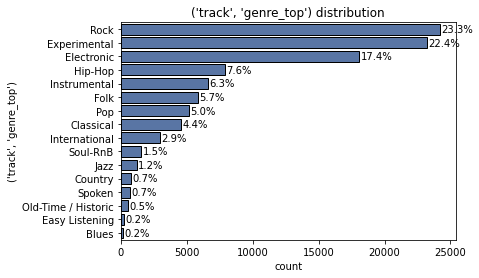

In [2838]:
column_name = ('track', 'genre_top')
sns_countplot(tracks, column_name, "", False, True)

<h6> ('album', 'type') after imputation </h6>

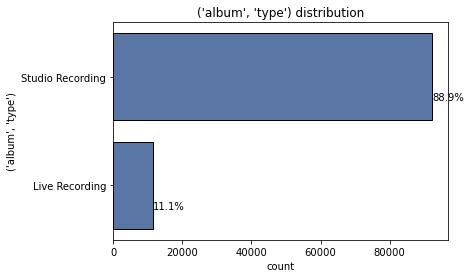

In [2839]:
column_name = ('album', 'type')
sns_countplot(tracks, column_name, "", False, True)

<font color="red"><h1>Filtered features DataSet</h1></font>

In [2840]:
to_keep_columns = [('track', 'genre_top'), ('set', 'split'), ('track', 'bit_rate'), ('track', 'duration'), 
                   ('track', 'listens'), ('track', 'date_created_year'),('track', 'date_created_season'), 
                   ('artist', 'id'), ('artist', 'favorites'), 
                   ('album', 'id'), ('album', 'favorites'), ('album', 'type')]

filtered_tracks = tracks[to_keep_columns]
filtered_tracks.shape

(103708, 12)

In [2841]:
filtered_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103708 entries, 2 to 155320
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   (track, genre_top)            103708 non-null  object
 1   (set, split)                  103708 non-null  object
 2   (track, bit_rate)             103708 non-null  int64 
 3   (track, duration)             103708 non-null  int64 
 4   (track, listens)              103708 non-null  int64 
 5   (track, date_created_year)    103708 non-null  object
 6   (track, date_created_season)  103708 non-null  object
 7   (artist, id)                  103708 non-null  int64 
 8   (artist, favorites)           103708 non-null  int64 
 9   (album, id)                   103708 non-null  int64 
 10  (album, favorites)            103708 non-null  int64 
 11  (album, type)                 103708 non-null  object
dtypes: int64(7), object(5)
memory usage: 15.3+ MB


In [2842]:
# save filtered DataFrame on file
filtered_tracks.to_csv('../../data/fma_metadata/new_tracks.csv', index=True, header=True)

<h6>echonest comparison</h6>

In [2843]:
# removed ties aren't present in echonestData dataset
len(remaining_ties) - len(set(remaining_ties).difference(set(echonestData.index)))

0

In [2844]:
# some removed, Contest/Single Tracks tracks in echonestData dataset
len(set(echonestData.index).difference(set(tracks.index)))

159

**By removing the 29 records having both bit_rate and genre_top set to NaN, we didn't removed any of records present in the Echonest dataset. Instead, 159 tracks belonging to Contest/Single Tracks or being label by used as outliers, were removed by our cleaning process.**

<h2>Check correlation after imputation</h2>

In [2846]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_tracks = tracks.select_dtypes(include=numerics)
del numeric_tracks[('album', 'id')]
del numeric_tracks[('album', 'tracks')]
del numeric_tracks[('artist', 'id')]
del numeric_tracks[('artist', 'latitude')]
del numeric_tracks[('artist', 'longitude')]
del numeric_tracks[('track', 'number')]
# del numeric_tracks[('track', 'date_created_year')]
numeric_tracks.shape

(103708, 11)

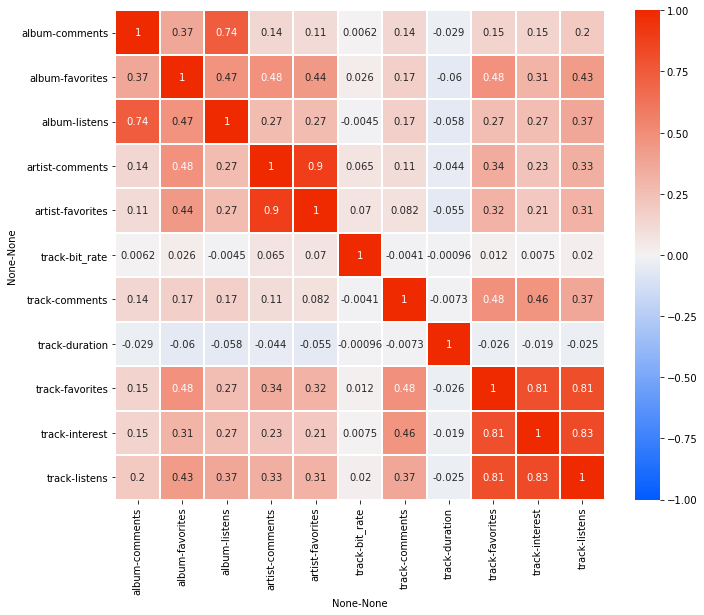

In [2847]:
norm_numeric_tracks = numeric_tracks.dropna().copy()  # N.B. = removing NaN values
# del norm_numeric_tracks[('track', 'date_created_year')]
norm_numeric_tracks = normalize_df(norm_numeric_tracks, "min_max")
corr = norm_numeric_tracks.corr()


f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(255, 30, 255, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, center=0.0, vmax = 1, vmin = -1, 
                      square=True, linewidths=1, ax=ax, annot=True)
plt.show()

<h2> Checking small, medium and larger sets before imputation</h2>

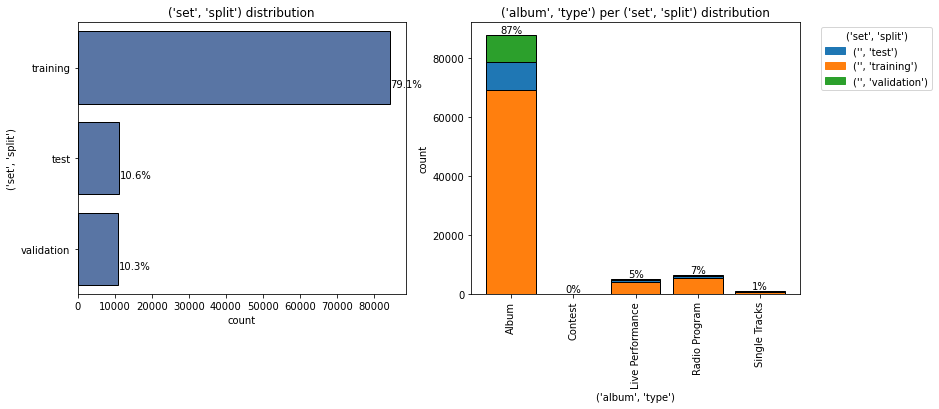

('set', 'split') per ('album', 'type'):
Album	training	78.8%
Album	test	10.8%
Album	validation	10.4%

Single Tracks	training	68.8%
Single Tracks	validation	19.4%
Single Tracks	test	11.8%

Live Performance	training	83.0%
Live Performance	test	10.4%
Live Performance	validation	6.5%

Radio Program	training	83.0%
Radio Program	test	8.6%
Radio Program	validation	8.4%

Contest	training	92.9%
Contest	test	7.1%
Contest	validation	0.0%



In [2848]:
column_name1 = ('album', 'type')
column_name2 = ('set', 'split')
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns_countplot(tracks_before_merging, column_name2, ax, False, True)
ax = plt.subplot2grid(fig_dims, (0, 1))
pclass_xt = draw_reversed_frequency_stacked_bar(tracks_before_merging, column_name1, column_name2, False, True, True, "")
plt.show()
# print_perc_column(tracks_before_merging, column_name2)
# print_hues_perc_column(tracks_before_merging, column_name2, column_name1)
print_hues_all_perc_column(tracks_before_merging, column_name2, column_name1)
# genre_zero_frequency_table_insight(pclass_xt,  tracks_before_merging, column_name2, column_name1)
# genre_max_frequency_table_insight(pclass_xt, tracks_before_merging, column_name2, column_name1)

<h2> Checking small, medium and larger sets before imputation, but afteralbum type cleaning </h2>

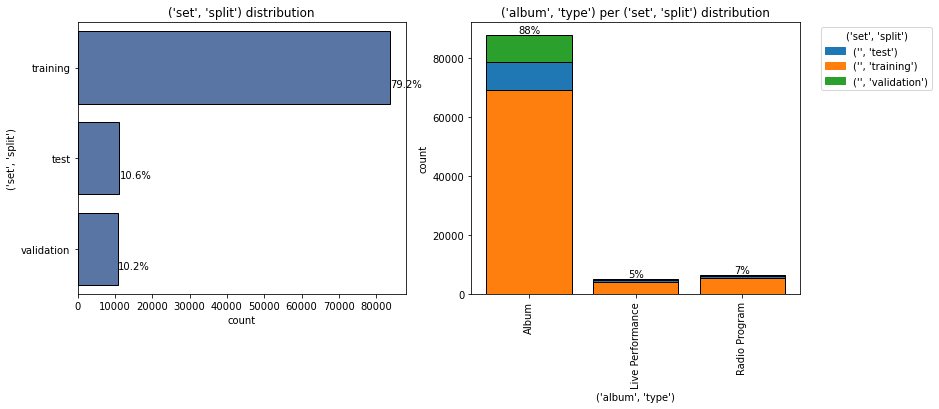

('set', 'split') per ('album', 'type'):
Album	training	78.8%
Album	test	10.8%
Album	validation	10.4%

Live Performance	training	83.0%
Live Performance	test	10.4%
Live Performance	validation	6.5%

Radio Program	training	83.0%
Radio Program	test	8.6%
Radio Program	validation	8.4%



In [2849]:
column_name1 = ('album', 'type')
column_name2 = ('set', 'split')
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns_countplot(tracks_filtered_album_types, column_name2, ax, False, True)
ax = plt.subplot2grid(fig_dims, (0, 1))
pclass_xt = draw_reversed_frequency_stacked_bar(tracks_filtered_album_types, column_name1, column_name2, False, True, True, "")
plt.show()
# print_perc_column(tracks_filtered_album_types, column_name2)
# print_hues_perc_column(tracks_filtered_album_types, column_name2, column_name1)
print_hues_all_perc_column(tracks_filtered_album_types, column_name2, column_name1)
# genre_zero_frequency_table_insight(pclass_xt,  tracks_filtered_album_types, column_name2, column_name1)
# genre_max_frequency_table_insight(pclass_xt, tracks_filtered_album_types, column_name2, column_name1)

<h2> Checking small, medium and larger sets after imputation </h2>

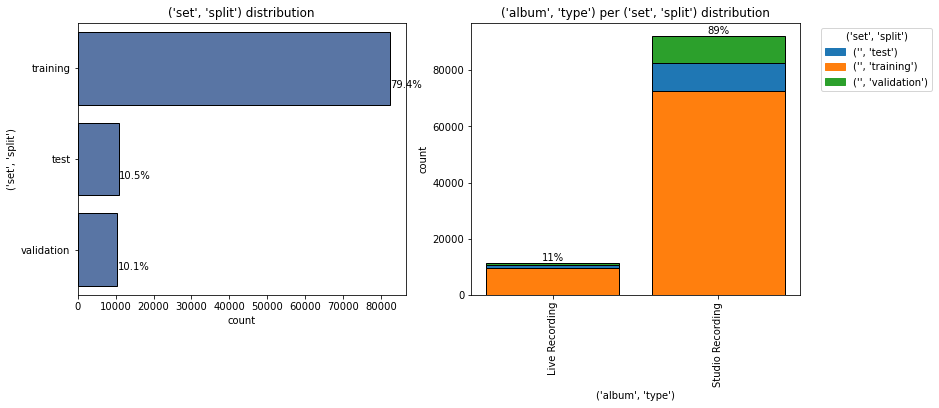

('set', 'split') per ('album', 'type'):
Studio Recording	training	78.9%
Studio Recording	test	10.6%
Studio Recording	validation	10.5%

Live Recording	training	83.1%
Live Recording	test	9.4%
Live Recording	validation	7.5%



In [2850]:
column_name1 = ('album', 'type')
column_name2 = ('set', 'split')
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns_countplot(tracks, column_name2, ax, False, True)
ax = plt.subplot2grid(fig_dims, (0, 1))
pclass_xt = draw_reversed_frequency_stacked_bar(tracks, column_name1, column_name2, False, True, True, "")
plt.show()
# print_perc_column(tracks, column_name2)
# print_hues_perc_column(tracks, column_name2, column_name1)
print_hues_all_perc_column(tracks, column_name2, column_name1)
# genre_zero_frequency_table_insight(pclass_xt,  tracks, column_name2, column_name1)
# genre_max_frequency_table_insight(pclass_xt, tracks, column_name2, column_name1)